In [9]:
def stringToList(input):
  lst = []
  for i in input:
    l = list(map(float, i.split(" ")))
    lst.append(l)
  return lst

In [8]:
def moodNamePrintFromLabel(n):
  if n == 0: result = 'Angry '
  elif n == 1: result = 'Disgust '
  elif n == 2: result = 'Fear'
  elif n == 3: result = 'Happy'
  elif n == 4: result = 'Sad'
  elif n == 5: result = 'Surprise'
  elif n == 6: result = 'Neutral'
  return result



In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pandas as pd
import numpy as np

In [10]:

data = pd.read_csv('/content/drive/My Drive/projects/train.csv')
test_data = pd.read_csv('/content/drive/My Drive/projects/test.csv')

**processing the data**

In [28]:
X = data['pixels']
Y = np.array(data['emotion'])

x_test_data = np.array(test_data['pixels'])

X = np.array(stringToList(X))/255.0
X = np.reshape(X, (28709, 48,48,1))

x_test_data = np.array(stringToList(x_test_data))
x_test_data = np.reshape(x_test_data, (7178,48,48,1)) /255.0


In [ ]:
print(X.shape)
print(Y.shape)

(28709, 48, 48, 1)
(28709,)


**data splitting to test and training set**

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

In [ ]:
print(x_train.shape)
print(y_train.shape)

(22967, 48, 48, 1)
(22967,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization

In [ ]:
model = Sequential()
#1st convo
model.add(Conv2D(96, (3,3), input_shape = (48,48,1)))
model.add(Activation('relu'))
#polling
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())


#2nd convo
model.add(Conv2D(256, (3,3)))
model.add(Activation('relu'))
#polling
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

#3rd convo
model.add(Conv2D(384, (3,3)))
model.add(Activation('relu'))
#polling
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

#4th convo
model.add(Conv2D(256, (3,3)))
model.add(Activation('relu'))
#polling
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())




#passing through dense layer
model.add(Flatten())

#1st dense layer
model.add(Dense(1024))
model.add(Activation('relu'))
#dropout
model.add(BatchNormalization())
model.add(Dropout(0.4))


#2nd dense layer
model.add(Dense(1024))
model.add(Activation('relu'))
#dropout
model.add(BatchNormalization())
model.add(Dropout(0.4))


#3rd dense layer
model.add(Dense(256))
model.add(Activation('relu'))
#dropout
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Activation('relu'))


#output layer
model.add(Dense(7))
model.add(Activation('softmax'))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "adam",
              metrics = ['sparse_categorical_accuracy'])
model.fit(x_train, y_train, batch_size=32, epochs=10, validation_split=0.1)

In [ ]:
model.save('/content/drive/My Drive/projects/model.h5')

**Loading the saved mood detection model from google drive**

In [11]:
from keras.models import load_model
loaded_model = load_model('/content/drive/My Drive/projects/model.h5')

In [ ]:
score = loaded_model.evaluate(x_test, y_test, verbose=1)

180/180 [==============================] - 37s 203ms/step - loss: 0.6828 - sparse_categorical_accuracy: 0.7654


**Taking input as image and videos and detecting faces and getting the face portion. Then passing these faces to the model and getting the mood detection output.**

In [109]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


def videoToMoodDetection(video_path):
  #video_cap = cv2.VideoCapture(0)
  video_cap = cv2.VideoCapture(video_path)

  while (video_cap.isOpened()):
    ret, frame = video_cap.read()

    Gray_img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = face_casecade.detectMultiScale(Gray_img, 1.3, 5)

    print(faces)

    for (x,y,w,h) in faces:
      pxl_lst = []
      for i in range(y, y+h):
        lst = []
        for j in range(x, x+w):
          lst.append(Gray_img[i][j])
        pxl_lst.append(lst)
      single_face = np.array(pxl_lst)
      
      print("/n/n/n/n/n/n/n")
      resized_img = cv2.resize(single_face, (48,48), interpolation = cv2.INTER_AREA)

      #printing the 48*48 pixel images which will be passed to the model
      cv2_imshow(resized_img)
      
      #resize for passing to the model
      resized_img = np.reshape(resized_img,(1,48,48,1))/255.0

      #passing to model
      result = np.argmax(loaded_model.predict(resized_img), axis=-1)
      if result is not None:
        print(moodNamePrintFromLabel(result))
  


def imageToMoodDetection(img_path):

  img = cv2.imread(img_path)

  Gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  faces = face_casecade.detectMultiScale(Gray_img, 1.3, 3)

  for (x,y,w,h) in faces:
      pxl_lst = []
      for i in range(y, y+h):
        lst = []
        for j in range(x, x+w):
          lst.append(Gray_img[i][j])
        pxl_lst.append(lst)
      single_face = np.array(pxl_lst)
      single_face = np.reshape(single_face,(h,w,))
      print(single_face)
  
      resized_img = cv2.resize(single_face, (48,48), interpolation = cv2.INTER_AREA)
      cv2_imshow(resized_img)
      print(resized_img.shape)
      resized_img = np.reshape(resized_img,(1,48,48,1))/255.0

      #passing to model
      result = np.argmax(loaded_model.predict(resized_img), axis=-1)
      if result is not None:
        print(moodNamePrintFromLabel(result))

  
  
  
  



[[43 34 29 ... 26 31 37]
 [33 29 27 ... 24 29 35]
 [24 25 27 ... 22 25 30]
 ...
 [50 50 51 ... 46 45 47]
 [50 51 53 ... 50 49 49]
 [53 51 51 ... 47 48 49]]


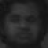

(48, 48)
Happy
[[ 68  45  39 ...  38  38  38]
 [ 65  44  40 ...  38  38  38]
 [ 60  46  43 ...  38  38  38]
 ...
 [192 198 199 ... 156 148 150]
 [182 188 184 ... 150 145 146]
 [162 161 169 ... 152 147 144]]


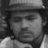

(48, 48)
Sad
[[ 29  33  36 ... 127 144 178]
 [ 27  33  32 ... 138 143 174]
 [ 29  29  28 ... 144 138 153]
 ...
 [ 20  21  21 ...  51  46  50]
 [ 22  20  18 ...  46  46  46]
 [ 22  20  18 ...  57  51  43]]


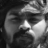

(48, 48)
Angry 


In [110]:
imageToMoodDetection('/content/DSC_2693.NEF.jpg')

()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
[[216  23 219 219]]
[[ 58  78 108 ... 107 112 101]
 [ 71  97 120 ... 110 111 102]
 [ 94 116 122 ... 102 103 100]
 ...
 [ 28  28  28 ...  45  49  52]
 [ 29  29  28 ...  45  49  53]
 [ 30  30  29 ...  45  49  53]]
/n/n/n/n/n/n/n


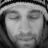

(48, 48)
Neutral
[[219  24 216 216]]
[[127 125 124 ... 110 108  98]
 [116 120 101 ... 100 101 100]
 [101 107  75 ...  82  93 100]
 ...
 [ 28  28  28 ...  46  50  53]
 [ 28  28  28 ...  46  50  53]
 [ 28  28  26 ...  46  50  53]]
/n/n/n/n/n/n/n


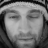

(48, 48)
Neutral
[[218  23 214 214]]
[[124 135 134 ...  46  82 107]
 [127 125 127 ...  26  73 105]
 [120 117 118 ...  15  52  87]
 ...
 [ 28  28  28 ...  37  37  39]
 [ 26  28  28 ...  37  38  39]
 [ 26  28  28 ...  35  38  40]]
/n/n/n/n/n/n/n


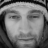

(48, 48)
Neutral
[[219  22 214 214]]
[[137 131 123 ... 103 111 112]
 [137 131 124 ... 103 111 111]
 [128 129 109 ...  96 108 109]
 ...
 [ 28  28  28 ...  38  39  40]
 [ 28  28  28 ...  39  40  42]
 [ 28  28  28 ...  38  40  43]]
/n/n/n/n/n/n/n


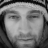

(48, 48)
Neutral
[[217  20 217 217]]
[[ 57 103 127 ... 112 109  97]
 [ 74 117 131 ... 112 112 101]
 [ 90 128 137 ... 111 112 102]
 ...
 [ 26  28  28 ...  40  42  46]
 [ 26  26  28 ...  40  43  47]
 [ 26  28  28 ...  43  44  50]]
/n/n/n/n/n/n/n


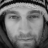

(48, 48)
Neutral
[[219  21 215 215]]
[[117 131 127 ... 109 114 111]
 [128 137 131 ... 104 112 111]
 [131 135 132 ... 103 112 110]
 ...
 [ 28  28  28 ...  40  40  43]
 [ 28  28  28 ...  39  40  44]
 [ 28  28  26 ...  39  42  45]]
/n/n/n/n/n/n/n


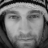

(48, 48)
Neutral
[[219  20 214 214]]
[[111 128 125 ... 104 112 112]
 [123 130 127 ...  96 110 114]
 [132 136 129 ...  88 107 112]
 ...
 [ 28  28  28 ...  38  38  38]
 [ 28  28  28 ...  38  39  39]
 [ 28  28  26 ...  38  40  40]]
/n/n/n/n/n/n/n


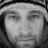

(48, 48)
Neutral
[[218  20 215 215]]
[[ 70 111 128 ... 100 111 112]
 [ 87 123 130 ...  91 108 114]
 [102 132 136 ...  81 103 112]
 ...
 [ 28  28  28 ...  38  40  39]
 [ 28  28  28 ...  37  40  40]
 [ 28  28  28 ...  35  39  40]]
/n/n/n/n/n/n/n


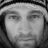

(48, 48)
Neutral
[[218  20 215 215]]
[[ 82 118 128 ... 100 111 112]
 [ 99 127 129 ...  91 108 114]
 [113 135 135 ...  81 103 112]
 ...
 [ 28  28  28 ...  38  40  39]
 [ 28  28  28 ...  37  40  40]
 [ 28  28  28 ...  35  39  40]]
/n/n/n/n/n/n/n


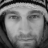

(48, 48)
Neutral
[[218  20 215 215]]
[[ 82 118 128 ... 100 111 112]
 [ 99 127 129 ...  91 108 114]
 [113 135 135 ...  81 103 112]
 ...
 [ 28  28  28 ...  38  40  39]
 [ 28  28  28 ...  37  40  40]
 [ 28  28  28 ...  35  39  40]]
/n/n/n/n/n/n/n


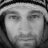

(48, 48)
Neutral
[[218  21 214 214]]
[[113 131 130 ...  67  93 108]
 [122 137 134 ...  49  83 107]
 [128 135 134 ...  30  73 103]
 ...
 [ 28  28  28 ...  37  35  37]
 [ 28  28  28 ...  37  35  35]
 [ 28  28  28 ...  36  33  35]]
/n/n/n/n/n/n/n


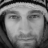

(48, 48)
Neutral
[[219  20 214 214]]
[[127 128 125 ... 103 112 108]
 [132 129 125 ...  97 110 108]
 [137 132 125 ...  90 109 108]
 ...
 [ 28  28  28 ...  36  37  38]
 [ 28  28  26 ...  36  36  38]
 [ 28  28  26 ...  35  37  39]]
/n/n/n/n/n/n/n


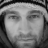

(48, 48)
Neutral
[[218  17 217 217]]
[[101 128 141 ...  87  72  61]
 [115 130 135 ...  96  80  66]
 [123 130 128 ... 102  88  69]
 ...
 [ 28  28  28 ...  39  42  45]
 [ 28  28  28 ...  39  43  47]
 [ 28  28  28 ...  40  45  50]]
/n/n/n/n/n/n/n


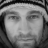

(48, 48)
Neutral
[[216  16 218 218]]
[[ 43  72 106 ...  83  74  66]
 [ 54  93 123 ...  94  77  64]
 [ 66 107 128 ... 101  85  69]
 ...
 [ 28  28  28 ...  37  39  43]
 [ 28  28  28 ...  38  40  45]
 [ 26  28  28 ...  38  43  48]]
/n/n/n/n/n/n/n


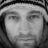

(48, 48)
Neutral
[[219  18 214 214]]
[[129 130 129 ... 107  97  80]
 [125 125 127 ... 107 102  86]
 [125 123 122 ... 108 102  87]
 ...
 [ 29  29  26 ...  36  37  37]
 [ 28  28  26 ...  37  37  38]
 [ 28  26  26 ...  37  38  39]]
/n/n/n/n/n/n/n


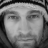

(48, 48)
Neutral
[[212  16 222 222]]
[[43 26 25 ... 71 63 61]
 [43 25 26 ... 78 66 60]
 [44 25 29 ... 85 67 59]
 ...
 [31 31 30 ... 42 44 46]
 [31 31 30 ... 42 44 46]
 [31 31 31 ... 42 44 46]]
/n/n/n/n/n/n/n


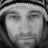

(48, 48)
Neutral
[[212  16 222 222]]
[[43 26 25 ... 71 63 61]
 [43 25 26 ... 78 66 60]
 [44 25 29 ... 85 67 59]
 ...
 [31 31 30 ... 42 44 46]
 [31 31 30 ... 42 44 46]
 [31 31 31 ... 43 44 46]]
/n/n/n/n/n/n/n


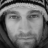

(48, 48)
Neutral
[[212  17 220 220]]
[[ 24  33  74 ...  97  80  68]
 [ 24  40  87 ... 102  86  67]
 [ 31  54 101 ... 102  88  68]
 ...
 [ 31  30  29 ...  36  38  39]
 [ 31  30  30 ...  35  38  40]
 [ 31  31  30 ...  36  38  40]]
/n/n/n/n/n/n/n


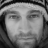

(48, 48)
Neutral
[[212  16 221 221]]
[[ 50  92 122 ...  63  58  57]
 [ 60 106 127 ...  60  56  54]
 [ 74 116 129 ...  61  58  57]
 ...
 [ 30  28  28 ...  40  43  46]
 [ 30  30  29 ...  42  44  46]
 [ 30  31  31 ...  42  43  45]]
/n/n/n/n/n/n/n


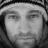

(48, 48)
Neutral
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
[[367  94 138 138]]
[[ 80  79  74 ...  22  13  43]
 [ 94  92  85 ...  40  25  33]
 [ 92  90  89 ...  35  19  21]
 ...
 [230 231 232 ... 243 243 243]
 [231 232 232 ... 243 243 243]
 [231 234 234 ... 244 244 244]]
/n/n/n/n/n/n/n


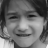

(48, 48)
Happy
[[366  93 139 139]]
[[ 77  68  70 ... 123  97  38]
 [ 88  73  78 ... 130 109  58]
 [ 87  81  87 ... 131 108  64]
 ...
 [230 230 231 ... 233 243 243]
 [230 231 231 ... 244 243 243]
 [230 231 231 ... 244 244 244]]
/n/n/n/n/n/n/n


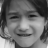

(48, 48)
Happy
[[370  94 135 135]]
[[ 89  92  85 ... 100 132 115]
 [ 93  93  90 ...  87 130 117]
 [ 93  90  93 ...  75 122 120]
 ...
 [231 232 232 ... 143 157 240]
 [231 232 234 ... 153 189 242]
 [232 232 232 ... 165 221 243]]
/n/n/n/n/n/n/n


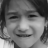

(48, 48)
Happy
[[368  92 139 139]]
[[ 67  67  67 ... 123  86  22]
 [ 74  71  75 ... 127 100  40]
 [ 79  78  85 ... 130 113  64]
 ...
 [230 231 232 ... 241 243 242]
 [231 231 232 ... 244 244 243]
 [231 233 234 ... 245 243 244]]
/n/n/n/n/n/n/n


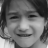

(48, 48)
Happy
[[368  91 138 138]]
[[ 68  66  65 ... 120 122 110]
 [ 71  71  64 ... 103 128 114]
 [ 80  75  70 ...  77 124 123]
 ...
 [231 230 231 ... 138 162 234]
 [231 231 232 ... 150 192 242]
 [231 231 232 ... 166 220 244]]
/n/n/n/n/n/n/n


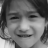

(48, 48)
Happy
[[368  91 139 139]]
[[ 68  67  66 ... 122 118 113]
 [ 70  74  71 ... 113 128 104]
 [ 78  81  75 ...  92 128 116]
 ...
 [231 231 232 ... 157 208 246]
 [230 231 232 ... 179 230 245]
 [230 233 232 ... 203 240 247]]
/n/n/n/n/n/n/n


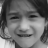

(48, 48)
Happy
[[371  89 141 141]]
[[ 89  89  85 ...  17  49  68]
 [ 80  73  64 ...   9  32  60]
 [ 58  61  59 ...  10  22  53]
 ...
 [231 232 234 ... 237 243 244]
 [231 232 232 ... 243 251 250]
 [233 232 234 ... 244 249 250]]
/n/n/n/n/n/n/n


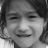

(48, 48)
Happy
[[369  89 143 143]]
[[ 73  77  85 ...  15  35  64]
 [ 77  78  81 ...  28  15  53]
 [ 70  70  61 ...  43   9  43]
 ...
 [230 231 233 ... 243 248 250]
 [230 231 233 ... 242 246 248]
 [230 230 233 ... 244 245 245]]
/n/n/n/n/n/n/n


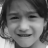

(48, 48)
Happy
[[371  91 141 141]]
[[ 66  58  60 ...  81  10  21]
 [ 64  59  60 ...  86  24  16]
 [ 75  67  66 ...  99  40  16]
 ...
 [231 234 232 ... 243 243 249]
 [233 234 234 ... 244 243 247]
 [231 234 234 ... 244 244 244]]
/n/n/n/n/n/n/n


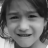

(48, 48)
Happy
[[372  92 140 140]]
[[ 66  61  61 ... 111  52  11]
 [ 79  71  68 ... 123  68  21]
 [ 89  85  80 ... 131  86  33]
 ...
 [234 234 232 ... 246 242 245]
 [234 234 235 ... 247 243 244]
 [234 234 234 ... 245 243 244]]
/n/n/n/n/n/n/n


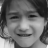

(48, 48)
Happy
[[367  90 146 146]]
[[ 79  78  77 ...  39  22  52]
 [ 67  68  67 ...  51  23  36]
 [ 65  66  68 ...  81  15  20]
 ...
 [208 214 226 ... 247 247 245]
 [207 213 224 ... 248 246 244]
 [210 214 223 ... 246 244 243]]
/n/n/n/n/n/n/n


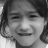

(48, 48)
Happy
[[370  92 142 142]]
[[ 68  67  65 ... 131  74  16]
 [ 82  82  79 ... 131  89  28]
 [ 89  93  90 ... 137 101  43]
 ...
 [227 230 234 ... 246 245 243]
 [228 230 231 ... 248 245 244]
 [227 229 231 ... 246 244 247]]
/n/n/n/n/n/n/n


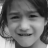

(48, 48)
Happy
[[376  94 134 134]]
[[ 78  79  79 ...  49 104 137]
 [ 86  88  87 ...  38  87 132]
 [ 89  89  92 ...  32  77 129]
 ...
 [232 232 234 ... 169 132 118]
 [232 234 234 ... 164 135 136]
 [234 234 234 ... 166 138 156]]
/n/n/n/n/n/n/n


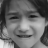

(48, 48)
Happy
[[376  94 137 137]]
[[ 74  79  79 ... 130  77  26]
 [ 85  87  88 ... 137 100  44]
 [ 92  89  90 ... 136 100  51]
 ...
 [234 234 234 ... 191 246 248]
 [234 234 234 ... 217 246 246]
 [234 235 234 ... 241 244 244]]
/n/n/n/n/n/n/n


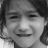

(48, 48)
Happy
[[377  94 136 136]]
[[ 75  80  79 ... 132 123  72]
 [ 86  88  88 ... 124 133  95]
 [ 90  89  92 ... 118 129 102]
 ...
 [234 234 234 ... 137 177 241]
 [234 234 234 ... 133 204 252]
 [234 234 234 ... 161 225 248]]
/n/n/n/n/n/n/n


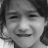

(48, 48)
Happy
[[379  94 134 134]]
[[ 80  80  86 ...  96 132 120]
 [ 88  88  92 ...  82 130 124]
 [ 89  93  94 ...  71 121 122]
 ...
 [234 234 234 ... 143 114 170]
 [234 234 234 ... 150 111 164]
 [234 234 234 ... 146 123 196]]
/n/n/n/n/n/n/n


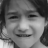

(48, 48)
Happy
[[380  90 136 136]]
[[ 58  58  67 ... 103  38  14]
 [ 60  63  65 ... 108  51  11]
 [ 67  68  68 ... 124  70  24]
 ...
 [234 234 234 ...  70  73  75]
 [234 234 234 ... 166 220 203]
 [234 234 234 ... 128 217 249]]
/n/n/n/n/n/n/n


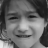

(48, 48)
Happy
[[381  89 136 136]]
[[ 70  65  68 ... 103  35  26]
 [ 58  65  73 ... 103  40  12]
 [ 64  65  71 ... 113  56  15]
 ...
 [234 232 232 ...  43  46  39]
 [234 234 234 ... 103 119  75]
 [234 234 234 ... 172 217 187]]
/n/n/n/n/n/n/n


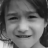

(48, 48)
Happy
[[381  93 134 134]]
[[ 78  79  82 ...  34  66 121]
 [ 85  87  89 ...  29  54 113]
 [ 88  93  94 ...  29  44  95]
 ...
 [234 234 234 ... 150 149 151]
 [232 234 234 ... 159 131 115]
 [234 234 234 ... 169 146 123]]
/n/n/n/n/n/n/n


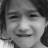

(48, 48)
Happy
[[382  94 133 133]]
[[ 88  90  89 ...  37  29  45]
 [ 90  94  94 ...  33  29  37]
 [ 90  93  92 ...  36  31  33]
 ...
 [234 234 234 ... 124 123 123]
 [232 234 234 ... 170 155 130]
 [234 234 234 ... 170 157 121]]
/n/n/n/n/n/n/n


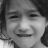

(48, 48)
Happy
[[383  93 133 133]]
[[ 78  80  79 ...  36  35  66]
 [ 87  89  88 ...  38  31  52]
 [ 90  94  94 ...  36  29  42]
 ...
 [234 232 235 ...  44  44  46]
 [234 234 235 ...  49  40  40]
 [234 234 234 ... 116 130 144]]
/n/n/n/n/n/n/n


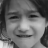

(48, 48)
Sad
[[382  92 138 138]]
[[ 68  64  63 ... 130 134 101]
 [ 74  71  70 ... 109 131 106]
 [ 80  78  77 ...  88 125 118]
 ...
 [232 234 234 ... 229 217  95]
 [234 234 234 ... 239 254 173]
 [234 234 234 ... 238 247 237]]
/n/n/n/n/n/n/n


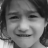

(48, 48)
Sad
[[382  94 136 136]]
[[ 80  75  75 ...  33  48  93]
 [ 84  82  81 ...  37  37  69]
 [ 87  85  87 ...  40  32  52]
 ...
 [232 234 234 ... 129 150 177]
 [234 234 234 ... 137 158 230]
 [234 234 234 ... 116 151 239]]
/n/n/n/n/n/n/n


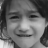

(48, 48)
Happy
[[383  94 137 137]]
[[ 77  73  73 ... 102 134 134]
 [ 81  79  78 ...  74 117 136]
 [ 87  85  86 ...  53 100 135]
 ...
 [234 234 234 ... 207 199  94]
 [234 234 235 ... 219 249 165]
 [234 234 235 ... 222 254 233]]
/n/n/n/n/n/n/n


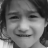

(48, 48)
Sad
[[385  96 135 135]]
[[ 82  84  85 ...  47  89 134]
 [ 88  88  88 ...  37  70 123]
 [ 90  88  87 ...  32  57 113]
 ...
 [234 233 235 ... 182 212 146]
 [234 233 233 ... 177 244 207]
 [235 235 234 ... 164 242 241]]
/n/n/n/n/n/n/n


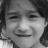

(48, 48)
Happy
[[385  97 134 134]]
[[ 82  82  84 ...  37  37  70]
 [ 88  88  88 ...  39  32  57]
 [ 90  88  90 ...  39  30  50]
 ...
 [234 234 236 ... 101 107 118]
 [234 234 235 ... 152 167 217]
 [234 235 234 ... 121 129 219]]
/n/n/n/n/n/n/n


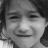

(48, 48)
Happy
[[381  97 140 140]]
[[ 89  89  86 ... 128 129 119]
 [ 93  90  88 ...  87 127 127]
 [ 96  93  90 ...  63 118 132]
 ...
 [234 234 235 ... 208 246 241]
 [234 235 235 ... 224 251 237]
 [235 235 235 ... 236 252 242]]
/n/n/n/n/n/n/n


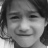

(48, 48)
Happy
[[386  99 135 135]]
[[ 80  82  82 ...  71 122 129]
 [ 87  92  93 ...  47  92 130]
 [ 99  96  97 ...  38  75 126]
 ...
 [234 235 236 ... 110 125 110]
 [234 234 235 ... 157 217 207]
 [235 234 233 ... 130 224 254]]
/n/n/n/n/n/n/n


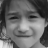

(48, 48)
Happy
[[386 103 134 134]]
[[116 116 122 ...  35  30  54]
 [129 128 124 ...  36  30  56]
 [139 141 127 ...  37  30  46]
 ...
 [235 235 233 ... 131 121 199]
 [235 235 234 ... 121 116 191]
 [235 235 235 ... 138 152 217]]
/n/n/n/n/n/n/n


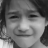

(48, 48)
Happy
[[384 104 134 134]]
[[ 93 104 118 ...  40  40  33]
 [104 130 131 ...  40  42  39]
 [149 151 136 ...  41  44  42]
 ...
 [234 234 235 ... 165 159 149]
 [235 235 235 ... 168 170 134]
 [235 235 235 ... 172 166 137]]
/n/n/n/n/n/n/n


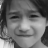

(48, 48)
Happy
[[387 106 131 131]]
[[122 143 144 ...  42  40  39]
 [136 153 138 ...  40  42  43]
 [150 136 116 ...  41  42  45]
 ...
 [236 237 235 ...  59  60  68]
 [235 237 237 ... 109  94 109]
 [234 236 237 ... 159 150 151]]
/n/n/n/n/n/n/n


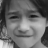

(48, 48)
Sad
[[388 108 133 133]]
[[129 150 149 ...  40  32  30]
 [143 149 124 ...  44  37  29]
 [148 130 115 ...  45  36  31]
 ...
 [234 235 237 ... 149 144 188]
 [234 235 235 ... 139 116 172]
 [235 235 235 ... 134 117 170]]
/n/n/n/n/n/n/n


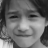

(48, 48)
Happy
[[387 111 133 133]]
[[173 145 148 ...  40  45  43]
 [159 148 138 ...  40  45  42]
 [162 146 118 ...  39  43  42]
 ...
 [234 235 235 ... 174 159 120]
 [235 235 235 ... 172 153 117]
 [235 235 236 ... 174 156 137]]
/n/n/n/n/n/n/n


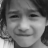

(48, 48)
Happy
[[389 111 133 133]]
[[136 150 138 ...  42  32  30]
 [143 146 122 ...  46  37  29]
 [146 130 114 ...  46  37  30]
 ...
 [235 235 235 ... 145 139 185]
 [235 235 235 ... 145 109 155]
 [235 235 236 ... 132 113 165]]
/n/n/n/n/n/n/n


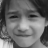

(48, 48)
Happy
[[389 111 132 132]]
[[145 131 149 ...  42  42  35]
 [148 141 151 ...  42  43  39]
 [150 146 138 ...  42  45  44]
 ...
 [234 235 238 ...  59  68  73]
 [235 235 236 ...  97 102 117]
 [235 235 235 ... 144 146 138]]
/n/n/n/n/n/n/n


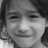

(48, 48)
Sad
[[391 114 130 130]]
[[146 131 118 ...  43  43  46]
 [137 117 138 ...  42  42  46]
 [120 124 158 ...  40  42  45]
 ...
 [236 238 236 ...  53  59  70]
 [236 236 237 ...  96  87  94]
 [235 235 236 ... 147 135 135]]
/n/n/n/n/n/n/n


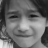

(48, 48)
Happy
[[390 113 136 136]]
[[115 125 144 ...  30  38  72]
 [127 156 149 ...  35  29  52]
 [149 171 152 ...  39  29  40]
 ...
 [235 236 236 ... 117 166 243]
 [236 236 236 ... 113 158 233]
 [236 236 236 ... 137 188 234]]
/n/n/n/n/n/n/n


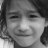

(48, 48)
Happy
[[391 114 135 135]]
[[122 143 153 ...  42  33  31]
 [135 166 158 ...  44  38  29]
 [153 173 157 ...  45  43  32]
 ...
 [235 236 235 ... 129 122 187]
 [236 236 236 ... 129 108 181]
 [236 236 237 ... 130 123 185]]
/n/n/n/n/n/n/n


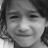

(48, 48)
Happy
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
[[302 139  51  51]]
[[ 86 114 111 ...  71  91 178]
 [136 126 145 ...  64  72 129]
 [104  60  79 ...  58  60  75]
 ...
 [ 40  41  38 ...  40  44  69]
 [ 43  45  41 ...  43  48 118]
 [ 47  51  51 ...  45  53 111]]
/n/n/n/n/n/n/n


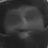

(48, 48)
Happy
()
[[300 145  52  52]]
[[129 150 130 ...  46  47  48]
 [ 93  93  88 ...  45  46  48]
 [ 29  30  32 ...  44  47  50]
 ...
 [ 86  79  72 ...  34  37  38]
 [109 133 126 ...  34  36  37]
 [146 171 165 ...  34  36  37]]
/n/n/n/n/n/n/n


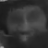

(48, 48)
Happy
[[299 149  52  52]]
[[ 71  74  73 ...  41  41  44]
 [ 26  27  30 ...  40  41  44]
 [ 33  33  33 ...  39  41  44]
 ...
 [110 160 137 ...  34  33  33]
 [125 115 129 ...  34  34  32]
 [117 116 137 ...  34  33  32]]
/n/n/n/n/n/n/n


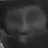

(48, 48)
Happy
[[297 151  52  52]]
[[ 54  58  61 ...  39  39  39]
 [ 37  37  34 ...  38  38  38]
 [ 36  33  32 ...  38  37  36]
 ...
 [100  90  93 ...  36  34  33]
 [ 78  66  72 ...  36  34  32]
 [ 72  62  55 ...  36  32  30]]
/n/n/n/n/n/n/n


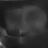

(48, 48)
Happy
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
[[229 117  63  63]]
[[ 11  11  11 ...  59  56  53]
 [ 11  11  11 ...  52  51  52]
 [ 11  11  11 ...  51  51  52]
 ...
 [  7   7   7 ... 138 139 135]
 [  7   7   7 ... 139 143 139]
 [  7   7   7 ... 142 144 141]]
/n/n/n/n/n/n/n


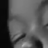

(48, 48)
Happy
()
()
()
()
()
()
()
()
()
()
()
[[190  96 138 138]]
[[10 11 10 ...  4  4  4]
 [10 11 10 ...  4  4  4]
 [ 9 10 10 ...  5  4  4]
 ...
 [ 8  7  7 ...  7  7  7]
 [ 7  7  7 ...  6  6  6]
 [ 7  7  7 ...  6  6  6]]
/n/n/n/n/n/n/n


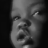

(48, 48)
Angry 
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
()
[[210  56  51  51]]
[[ 60  44  28 ... 161 156 153]
 [ 53  36  16 ... 161 156 153]
 [ 47  28   8 ... 161 156 152]
 ...
 [ 73  64  31 ...  79  81  87]
 [ 70  59  31 ...  44  45  45]
 [ 65  54  31 ...  44  46  57]]
/n/n/n/n/n/n/n


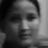

(48, 48)
Sad
[[205  56  52  52]]
[[158  74  11 ... 159 162 163]
 [121  49  11 ... 159 162 163]
 [ 74  15  11 ... 159 162 162]
 ...
 [ 87  82  67 ...  82  88  97]
 [ 99  95  84 ...  63  71  87]
 [103 101  90 ...  57  65  80]]
/n/n/n/n/n/n/n


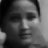

(48, 48)
Sad
[[203  55  51  51]]
[[ 89  26  10 ... 163 162 160]
 [ 47   8  10 ... 163 162 160]
 [ 26   5   6 ... 163 162 162]
 ...
 [ 95  94  86 ... 146 146 148]
 [ 58  65  70 ... 142 141 142]
 [ 67  65  58 ... 136 137 138]]
/n/n/n/n/n/n/n


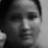

(48, 48)
Sad
[[203  51  52  52]]
[[152  30  15 ... 157 152 145]
 [ 65   6   5 ... 157 152 145]
 [ 30   4   4 ... 157 152 145]
 ...
 [ 56  53  37 ... 150 144 139]
 [ 56  47  31 ... 150 143 139]
 [ 54  42  24 ... 149 143 139]]
/n/n/n/n/n/n/n


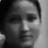

(48, 48)
Sad
[[201  49  54  54]]
[[ 25   4   4 ... 170 169 169]
 [  5   4   4 ... 170 170 170]
 [  2   4   4 ... 170 170 170]
 ...
 [ 60  43  24 ... 167 167 166]
 [ 65  47  30 ... 166 166 165]
 [ 74  58  40 ... 163 163 163]]
/n/n/n/n/n/n/n


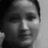

(48, 48)
Happy
[[203  46  52  52]]
[[  5   4   4 ... 167 166 164]
 [  5   4   4 ... 166 166 164]
 [  3   2   3 ... 165 163 157]
 ...
 [ 18   5   5 ... 167 165 163]
 [  9   5   5 ... 169 167 164]
 [  6   5   5 ... 167 166 164]]
/n/n/n/n/n/n/n


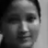

(48, 48)
Happy
[[202  44  56  56]]
[[  4   4   1 ...  77  77  77]
 [  3   4   2 ...  77  77  75]
 [  3   3   1 ...  79  77  74]
 ...
 [159 151  75 ...  61  61  63]
 [159 155 121 ...  59  59  60]
 [162 158 146 ...  58  59  59]]
/n/n/n/n/n/n/n


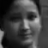

(48, 48)
Sad
[[207  41  59  59]]
[[  5   4   4 ...  84  93 110]
 [  6   4   3 ...  81  89 104]
 [  5   4   3 ...  77  85  96]
 ...
 [156 137 100 ...  92  95 103]
 [158 151 136 ...  93  96 101]
 [149 142 131 ...  90  99 101]]
/n/n/n/n/n/n/n


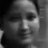

(48, 48)
Sad
[[217  41  56  56]]
[[  2   3   3 ...  85  87 113]
 [  2   3   3 ...  88  90 114]
 [  3   3   3 ...  90  93 114]
 ...
 [  5   6  10 ... 111 116 124]
 [  5   6   9 ... 124 129 136]
 [  6   6   9 ... 113 115 114]]
/n/n/n/n/n/n/n


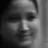

(48, 48)
Happy
[[225  39  58  58]]
[[  2   2   3 ... 152 152 153]
 [  2   2   2 ... 153 153 153]
 [  3   2   2 ... 153 154 154]
 ...
 [  6   7  10 ... 124 122 118]
 [  6   7   9 ... 112 110 108]
 [  6   8  11 ... 111 109 107]]
/n/n/n/n/n/n/n


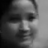

(48, 48)
Happy
[[235  38  57  57]]
[[  3   3   4 ... 156 157 158]
 [  3   3   3 ... 156 157 159]
 [  2   4   4 ... 157 157 158]
 ...
 [  9  10  10 ... 136 143 144]
 [  8  10  10 ... 134 139 144]
 [  9  10  10 ... 134 138 142]]
/n/n/n/n/n/n/n


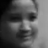

(48, 48)
Happy
[[244  35  59  59]]
[[  3   3   3 ... 128 131 135]
 [  2   2   3 ... 128 131 135]
 [  2   2   4 ... 129 133 136]
 ...
 [ 10  10  10 ... 127 134 137]
 [ 10  10  10 ... 127 134 137]
 [ 10  10  10 ... 127 134 137]]
/n/n/n/n/n/n/n


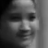

(48, 48)
Happy
[[254  31  60  60]]
[[  4   4   4 ... 144 144 144]
 [  4   4   4 ... 144 145 145]
 [  3   3   3 ... 144 144 144]
 ...
 [ 10  10  11 ... 146 148 148]
 [ 10  10  12 ... 146 146 146]
 [ 10  11  12 ... 146 146 146]]
/n/n/n/n/n/n/n


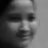

(48, 48)
Happy
[[261  27  62  62]]
[[  3   4   4 ... 139 139 139]
 [  2   3   3 ... 142 142 142]
 [  2   3   3 ... 142 142 142]
 ...
 [ 10  11  12 ... 144 143 143]
 [ 11  12  12 ... 143 143 143]
 [ 11  11  12 ... 143 143 143]]
/n/n/n/n/n/n/n


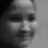

(48, 48)
Happy
[[264  27  62  62]]
[[ 3  3  3 ... 71 71 71]
 [ 3  3  3 ... 75 75 74]
 [ 3  3  3 ... 79 78 77]
 ...
 [ 9  9 12 ... 54 54 54]
 [10 10 12 ... 52 52 52]
 [11 11 12 ... 51 51 51]]
/n/n/n/n/n/n/n


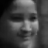

(48, 48)
Angry 
[[271  30  59  59]]
[[ 3  3  3 ... 88 88 87]
 [ 3  3  3 ... 87 86 85]
 [ 2  3  3 ... 87 87 86]
 ...
 [14 17 17 ... 66 64 63]
 [15 16 17 ... 66 64 61]
 [15 16 16 ... 67 65 63]]
/n/n/n/n/n/n/n


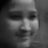

(48, 48)
Sad
[[269  27  64  64]]
[[ 1  2  3 ... 72 73 73]
 [ 2  2  2 ... 72 73 73]
 [ 2  2  2 ... 72 73 73]
 ...
 [16 16 16 ... 64 64 65]
 [17 17 17 ... 66 68 70]
 [17 17 17 ... 68 71 73]]
/n/n/n/n/n/n/n


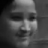

(48, 48)
Sad
[[264  28  60  60]]
[[ 2  2  2 ... 82 80 80]
 [ 2  2  2 ... 83 82 82]
 [ 2  2  2 ... 83 83 83]
 ...
 [17 17 17 ... 61 63 63]
 [18 18 18 ... 70 71 72]
 [19 18 19 ... 70 71 71]]
/n/n/n/n/n/n/n


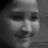

(48, 48)
Sad
[[252  20  73  73]]
[[ 2  2  2 ... 61 60 60]
 [ 2  2  2 ... 61 61 61]
 [ 2  2  2 ... 63 63 63]
 ...
 [21 22 24 ... 47 49 49]
 [22 23 24 ... 50 51 51]
 [23 24 25 ... 50 51 51]]
/n/n/n/n/n/n/n


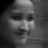

(48, 48)
Sad
[[248  22  62  62]]
[[ 2  2  2 ... 41 40 40]
 [ 2  2  2 ... 41 40 40]
 [ 2  2  1 ... 41 41 41]
 ...
 [19 22 23 ... 26 26 29]
 [18 19 19 ... 28 28 29]
 [18 19 19 ... 29 29 30]]
/n/n/n/n/n/n/n


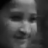

(48, 48)
Sad
[[234  20  68  68]]
[[ 1  1  1 ... 44 44 44]
 [ 1  1  1 ... 45 45 45]
 [ 2  2  2 ... 46 46 46]
 ...
 [19 19 22 ... 54 56 54]
 [21 21 22 ... 56 56 56]
 [21 21 22 ... 57 57 56]]
/n/n/n/n/n/n/n


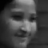

(48, 48)
Sad
()
[[215  16  74  74]]
[[ 2  2  2 ... 33 33 32]
 [ 2  2  2 ... 33 33 33]
 [ 2  2  2 ... 33 33 35]
 ...
 [21 22 22 ... 45 45 45]
 [23 22 22 ... 45 45 45]
 [25 23 23 ... 44 45 45]]
/n/n/n/n/n/n/n


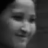

(48, 48)
Sad
[[205  15  77  77]]
[[ 2  1  1 ... 32 32 32]
 [ 2  2  2 ... 31 31 31]
 [ 2  2  2 ... 31 31 31]
 ...
 [24 23 23 ... 29 28 29]
 [26 25 25 ... 29 28 29]
 [28 28 28 ... 28 28 28]]
/n/n/n/n/n/n/n


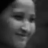

(48, 48)
Sad
[[203  15  71  71]]
[[ 1  1  1 ... 22 21 21]
 [ 2  2  2 ... 19 21 21]
 [ 2  2  2 ... 19 21 21]
 ...
 [19 21 21 ... 29 28 28]
 [22 22 22 ... 28 28 26]
 [22 22 23 ... 28 26 26]]
/n/n/n/n/n/n/n


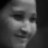

(48, 48)
Angry 
[[203  15  71  71]]
[[ 1  1  1 ... 22 21 21]
 [ 2  2  2 ... 19 21 21]
 [ 2  2  2 ... 19 21 21]
 ...
 [19 21 21 ... 29 28 28]
 [22 22 22 ... 28 28 26]
 [22 22 23 ... 28 26 26]]
/n/n/n/n/n/n/n


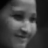

(48, 48)
Angry 
()
()
()
()
[[202   9  80  80]]
[[  3   3   4 ...   7   7   8]
 [  3   3   4 ...   7   7   8]
 [  3   3   4 ...   7   7   8]
 ...
 [ 28  28  28 ... 120 120 120]
 [ 28  28  28 ... 121 121 120]
 [ 26  28  28 ... 115 115 115]]
/n/n/n/n/n/n/n


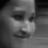

(48, 48)
Sad
()
()
()
()
[[460 261  74  74]]
[[191 191 189 ... 185 185 185]
 [192 192 192 ... 185 185 185]
 [193 193 192 ... 187 187 187]
 ...
 [ 38  39  38 ... 125 124 123]
 [ 37  37  38 ... 122 122 121]
 [ 44  43  42 ... 120 120 118]]
/n/n/n/n/n/n/n


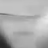

(48, 48)
Happy
[[333 248 107 107]]
[[ 51  50  50 ... 155 153 152]
 [ 51  50  49 ... 152 151 151]
 [ 49  46  45 ... 151 150 149]
 ...
 [ 36  35  35 ... 181 180 179]
 [ 35  35  35 ... 180 179 178]
 [ 35  35  35 ... 172 171 170]]
/n/n/n/n/n/n/n


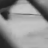

(48, 48)
Surprise
[[372 260  72  72]]
[[ 37  37  37 ...  84  90  99]
 [ 36  36  37 ...  75  82  88]
 [ 35  35  35 ...  68  73  79]
 ...
 [121 125 132 ... 191 189 189]
 [117 120 127 ... 191 189 189]
 [114 117 122 ... 192 189 189]]
/n/n/n/n/n/n/n


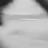

(48, 48)
Happy
()
()
()
()
()
()
()
()
[[304 252  95  95]]
[[ 5  5  6 ...  1  2  3]
 [ 6  6  8 ...  1  2  3]
 [ 6  6  8 ...  2  2  2]
 ...
 [61 65 67 ... 67 88 94]
 [60 61 65 ... 59 74 84]
 [59 60 63 ... 53 60 74]]
/n/n/n/n/n/n/n


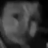

(48, 48)
Sad
[[296 232  96  96]]
[[ 1  2  1 ... 32 42 51]
 [ 2  2  2 ... 30 44 52]
 [ 2  3  2 ... 32 47 54]
 ...
 [68 79 85 ...  5  5  4]
 [65 73 80 ...  7  6  6]
 [59 66 77 ...  8  8  8]]
/n/n/n/n/n/n/n


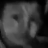

(48, 48)
Sad
[[287 214 100 100]]
[[ 2  1  1 ... 86 90 93]
 [ 2  1  1 ... 89 93 95]
 [ 2  1  1 ... 92 95 95]
 ...
 [45 45 51 ... 31 29 29]
 [42 40 48 ... 29 26 26]
 [42 39 46 ... 25 25 24]]
/n/n/n/n/n/n/n


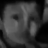

(48, 48)
Sad
[[280 200  99  99]]
[[ 1  1  1 ... 73 74 75]
 [ 1  1  1 ... 73 74 75]
 [ 1  1  1 ... 71 74 74]
 ...
 [52 58 61 ...  6  8  8]
 [47 50 56 ...  6  6  6]
 [43 45 55 ...  5  5  5]]
/n/n/n/n/n/n/n


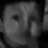

(48, 48)
Sad
[[281 201  99  99]]
[[ 1  1  1 ... 74 75 77]
 [ 1  1  1 ... 74 74 75]
 [ 1  1  1 ... 72 75 75]
 ...
 [50 56 64 ...  6  6  8]
 [45 55 65 ...  5  5  6]
 [44 54 65 ...  4  5  6]]
/n/n/n/n/n/n/n


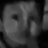

(48, 48)
Sad
[[273 191 102 102]]
[[ 1  1  1 ... 85 84 82]
 [ 1  1  1 ... 84 82 81]
 [ 1  1  1 ... 84 82 80]
 ...
 [47 47 47 ...  8  8  8]
 [46 45 44 ...  8  8  8]
 [45 44 43 ...  9  9  9]]
/n/n/n/n/n/n/n


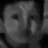

(48, 48)
Sad
[[266 182 103 103]]
[[ 1  1  1 ... 84 82 82]
 [ 1  1  1 ... 84 82 82]
 [ 1  1  1 ... 84 84 81]
 ...
 [51 51 54 ...  5  3  2]
 [49 49 51 ...  5  4  2]
 [48 48 49 ...  4  3  3]]
/n/n/n/n/n/n/n


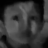

(48, 48)
Sad
[[262 179 101 101]]
[[ 2  2  1 ... 84 82 81]
 [ 1  1  1 ... 82 81 81]
 [ 1  1  1 ... 80 81 82]
 ...
 [63 66 73 ...  9  6  6]
 [54 57 63 ...  7  5  4]
 [51 51 53 ...  7  5  5]]
/n/n/n/n/n/n/n


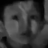

(48, 48)
Sad
[[258 173 101 101]]
[[ 1  1  1 ... 87 87 86]
 [ 1  1  1 ... 88 87 86]
 [ 1  1  1 ... 88 87 86]
 ...
 [74 75 77 ... 38 33 29]
 [71 71 74 ... 34 29 22]
 [65 67 71 ... 32 27 19]]
/n/n/n/n/n/n/n


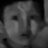

(48, 48)
Sad
[[254 165 101 101]]
[[ 2  1  1 ... 88 89 89]
 [ 2  1  1 ... 87 87 89]
 [ 1  1  1 ... 86 86 87]
 ...
 [84 81 83 ... 51 50 49]
 [80 80 80 ... 50 50 51]
 [74 75 78 ... 47 47 47]]
/n/n/n/n/n/n/n


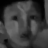

(48, 48)
Sad
[[250 157 102 102]]
[[ 2  2  2 ... 88 88 89]
 [ 1  1  1 ... 88 88 88]
 [ 1  1  1 ... 86 86 87]
 ...
 [88 90 88 ... 54 53 52]
 [90 88 86 ... 51 51 51]
 [85 82 81 ... 50 49 47]]
/n/n/n/n/n/n/n


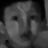

(48, 48)
Neutral
[[248 151 102 102]]
[[ 2  2  2 ... 87 88 88]
 [ 2  2  2 ... 87 88 88]
 [ 2  2  2 ... 86 87 87]
 ...
 [68 75 85 ... 60 60 60]
 [80 87 90 ... 59 60 61]
 [88 90 89 ... 57 59 59]]
/n/n/n/n/n/n/n


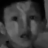

(48, 48)
Neutral
[[244 148 104 104]]
[[  2   2   2 ... 101  99  99]
 [  2   1   1 ... 101  99  97]
 [  2   2   2 ... 101  99  97]
 ...
 [ 60  68  77 ...  53  56  56]
 [ 70  79  86 ...  49  50  51]
 [ 81  86  90 ...  46  49  49]]
/n/n/n/n/n/n/n


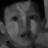

(48, 48)
Neutral
[[241 146 104 104]]
[[  1   1   1 ... 102 101 101]
 [  1   1   1 ... 102 101 100]
 [  1   1   1 ... 101 100  97]
 ...
 [ 53  57  63 ...  51  51  52]
 [ 58  65  75 ...  49  50  50]
 [ 68  76  85 ...  49  50  50]]
/n/n/n/n/n/n/n


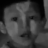

(48, 48)
Neutral
[[238 146 103 103]]
[[  1   1   1 ... 106 104 103]
 [  1   1   1 ... 107 104 103]
 [  1   1   1 ... 107 104 103]
 ...
 [ 49  52  56 ...  47  49  49]
 [ 51  54  66 ...  47  47  47]
 [ 59  68  77 ...  50  51  51]]
/n/n/n/n/n/n/n


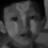

(48, 48)
Neutral
[[235 144 105 105]]
[[  1   1   1 ... 107 108 107]
 [  1   1   1 ... 106 107 107]
 [  1   1   1 ... 106 106 106]
 ...
 [ 45  45  46 ...  47  48  48]
 [ 46  46  46 ...  48  50  50]
 [ 46  53  63 ...  51  51  51]]
/n/n/n/n/n/n/n


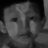

(48, 48)
Neutral
[[233 145 104 104]]
[[  1   1   1 ... 107 107 106]
 [  1   1   1 ... 107 107 106]
 [  1   1   1 ... 107 107 106]
 ...
 [ 44  45  44 ...  48  48  48]
 [ 45  45  46 ...  52  53  52]
 [ 45  47  53 ...  53  53  53]]
/n/n/n/n/n/n/n


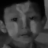

(48, 48)
Neutral
[[230 146 106 106]]
[[  2   1   1 ... 107 106 106]
 [  2   1   1 ... 107 106 106]
 [  1   1   1 ... 106 106 106]
 ...
 [ 45  47  49 ...  54  54  54]
 [ 45  49  53 ...  56  56  57]
 [ 50  54  64 ...  54  56  57]]
/n/n/n/n/n/n/n


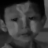

(48, 48)
Neutral
[[230 151 102 102]]
[[  1   1   1 ... 104 107 106]
 [  1   1   1 ... 103 106 106]
 [  1   1   1 ... 102 106 106]
 ...
 [ 44  44  43 ...  47  51  52]
 [ 44  44  44 ...  50  53  55]
 [ 49  47  47 ...  51  53  54]]
/n/n/n/n/n/n/n


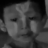

(48, 48)
Neutral
[[224 151 109 109]]
[[  2   2   2 ... 104 104 103]
 [  2   2   1 ... 102 102 102]
 [  2   2   1 ... 101 101 101]
 ...
 [ 46  47  46 ...  57  57  58]
 [ 45  47  46 ...  57  57  59]
 [ 45  47  52 ...  59  59  60]]
/n/n/n/n/n/n/n


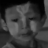

(48, 48)
Neutral
[[225 155 105 105]]
[[  1   1   2 ... 103 103 101]
 [  2   2   2 ... 103 103 102]
 [  2   2   2 ... 103 103 103]
 ...
 [ 46  45  46 ...  52  53  53]
 [ 47  46  47 ...  53  53  54]
 [ 47  47  52 ...  53  54  56]]
/n/n/n/n/n/n/n


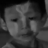

(48, 48)
Neutral
[[224 157 105 105]]
[[  2   2   2 ... 102 103 103]
 [  2   2   2 ... 102 103 104]
 [  2   2   2 ... 102 104 104]
 ...
 [ 45  47  47 ...  54  54  53]
 [ 46  47  52 ...  54  54  54]
 [ 47  53  60 ...  53  54  56]]
/n/n/n/n/n/n/n


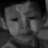

(48, 48)
Neutral
[[224 157 104 104]]
[[  1   1   2 ... 101 102 103]
 [  1   1   2 ... 100 102 103]
 [  1   1   2 ... 101 102 104]
 ...
 [ 46  47  46 ...  54  54  53]
 [ 45  47  49 ...  53  54  54]
 [ 47  49  54 ...  53  54  54]]
/n/n/n/n/n/n/n


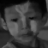

(48, 48)
Neutral
[[223 156 107 107]]
[[  1   1   1 ... 103 103 102]
 [  1   1   1 ... 103 104 104]
 [  1   1   1 ... 104 104 104]
 ...
 [ 44  44  45 ...  54  54  56]
 [ 45  43  49 ...  53  56  57]
 [ 43  49  63 ...  54  54  54]]
/n/n/n/n/n/n/n


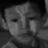

(48, 48)
Neutral
[[223 157 109 109]]
[[  2   2   1 ... 104 104 104]
 [  2   1   1 ... 104 104 104]
 [  2   1   1 ... 104 103 103]
 ...
 [ 43  45  64 ...  54  53  54]
 [ 53  66  87 ...  52  52  54]
 [ 74  89  95 ...  52  52  54]]
/n/n/n/n/n/n/n


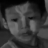

(48, 48)
Neutral
[[223 160 105 105]]
[[ 7  3  2 ... 15 56 92]
 [ 8  3  2 ... 16 56 88]
 [10  5  3 ... 15 47 80]
 ...
 [44 44 45 ... 47 52 53]
 [44 44 46 ... 46 51 52]
 [44 44 60 ... 49 52 54]]
/n/n/n/n/n/n/n


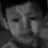

(48, 48)
Sad
[[225 164 102 102]]
[[16  9  8 ...  4  4  3]
 [19 10  8 ...  4  4  3]
 [22 12 10 ...  3  4  3]
 ...
 [44 45 47 ... 45 51 51]
 [45 47 57 ... 43 47 50]
 [51 67 81 ... 43 46 49]]
/n/n/n/n/n/n/n


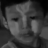

(48, 48)
Sad
[[226 162 107 107]]
[[  8   4   2 ...  56  92 103]
 [ 11   5   4 ...  56  92 101]
 [ 17  10   8 ...  53  87  96]
 ...
 [ 47  54  71 ...  54  55  54]
 [ 63  79  89 ...  54  54  53]
 [ 85  94  92 ...  52  52  53]]
/n/n/n/n/n/n/n


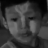

(48, 48)
Neutral
[[226 162 107 107]]
[[  8   4   2 ...  56  92 103]
 [ 11   5   4 ...  56  92 101]
 [ 17  10   8 ...  53  87  96]
 ...
 [ 47  54  71 ...  54  55  54]
 [ 63  79  89 ...  54  54  53]
 [ 85  94  92 ...  52  52  53]]
/n/n/n/n/n/n/n


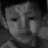

(48, 48)
Neutral
[[227 163 106 106]]
[[14  7  4 ...  4 32 78]
 [19 12  8 ...  5 32 77]
 [24 15  9 ...  5 30 70]
 ...
 [46 50 54 ... 53 53 54]
 [45 50 68 ... 51 53 54]
 [50 61 82 ... 53 53 53]]
/n/n/n/n/n/n/n


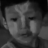

(48, 48)
Sad
[[225 162 108 108]]
[[25 18 11 ...  5  4 18]
 [23 18 12 ...  6  3 12]
 [28 22 15 ...  4  3 14]
 ...
 [44 46 45 ... 52 54 54]
 [43 44 45 ... 51 52 53]
 [43 44 46 ... 51 52 53]]
/n/n/n/n/n/n/n


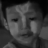

(48, 48)
Neutral
[[225 164 109 109]]
[[33 23 16 ...  6  4 10]
 [30 21 16 ...  6  4  8]
 [31 23 18 ...  6  4 10]
 ...
 [39 39 39 ... 52 52 53]
 [40 40 40 ... 51 52 52]
 [40 42 43 ... 52 52 52]]
/n/n/n/n/n/n/n


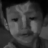

(48, 48)
Sad
[[226 165 109 109]]
[[29 18  8 ...  5  6  7]
 [24 16  8 ...  5  6  7]
 [22 16  9 ...  5  6  8]
 ...
 [39 39 38 ... 54 54 54]
 [39 39 38 ... 53 55 54]
 [39 39 38 ... 53 54 53]]
/n/n/n/n/n/n/n


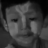

(48, 48)
Sad
[[226 167 110 110]]
[[24 12  7 ...  3  4  5]
 [25 14  5 ...  3  4  5]
 [25 14  7 ...  3  4  5]
 ...
 [39 39 39 ... 54 54 54]
 [39 39 39 ... 52 54 54]
 [39 39 39 ... 52 54 54]]
/n/n/n/n/n/n/n


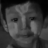

(48, 48)
Sad
[[225 170 113 113]]
[[28 19  9 ...  5 10 42]
 [29 19  9 ...  3 10 49]
 [30 19 10 ...  4 10 45]
 ...
 [32 32 35 ... 54 52 53]
 [32 32 32 ... 53 52 52]
 [31 32 32 ... 53 52 52]]
/n/n/n/n/n/n/n


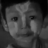

(48, 48)
Neutral
[[223 168 119 119]]
[[35 34 27 ... 88 89 86]
 [33 32 25 ... 86 90 86]
 [33 32 25 ... 81 90 86]
 ...
 [32 32 32 ... 58 57 58]
 [31 32 32 ... 58 57 58]
 [31 32 32 ... 58 57 57]]
/n/n/n/n/n/n/n


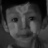

(48, 48)
Neutral
[[222 171 119 119]]
[[28 31 29 ... 28 66 90]
 [28 31 29 ... 23 60 88]
 [26 29 28 ... 23 57 86]
 ...
 [32 32 32 ... 59 60 59]
 [31 31 33 ... 58 58 58]
 [31 32 33 ... 57 57 57]]
/n/n/n/n/n/n/n


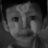

(48, 48)
Neutral
[[219 166 127 127]]
[[23 24 26 ... 84 84 84]
 [23 24 26 ... 84 85 85]
 [24 25 26 ... 84 86 87]
 ...
 [36 36 35 ... 57 58 58]
 [36 36 35 ... 56 57 56]
 [37 37 35 ... 54 56 56]]
/n/n/n/n/n/n/n


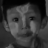

(48, 48)
Neutral
[[220 163 128 128]
 [524 260  51  51]]
[[24 26 29 ... 85 86 88]
 [24 26 28 ... 84 84 86]
 [24 26 28 ... 85 85 86]
 ...
 [36 36 36 ... 58 58 59]
 [36 36 36 ... 58 57 57]
 [38 37 36 ... 56 56 57]]
/n/n/n/n/n/n/n


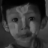

(48, 48)
Neutral
[[25 25 24 ...  4  3  3]
 [25 25 24 ...  8  5  4]
 [26 26 24 ...  9  7  4]
 ...
 [66 72 75 ... 74 72 68]
 [70 74 78 ... 75 73 71]
 [75 79 82 ... 75 73 71]]
/n/n/n/n/n/n/n


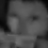

(48, 48)
Happy
[[222 164 124 124]
 [524 256  53  53]]
[[27 30 28 ... 88 90 85]
 [27 30 30 ... 85 92 87]
 [30 32 28 ... 79 90 87]
 ...
 [33 35 36 ... 60 59 59]
 [37 38 38 ... 60 59 58]
 [37 39 39 ... 58 58 58]]
/n/n/n/n/n/n/n


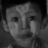

(48, 48)
Neutral
[[25 25 25 ...  2  2  1]
 [25 25 25 ...  2  2  1]
 [25 25 25 ...  3  2  1]
 ...
 [64 68 74 ... 73 72 68]
 [68 72 77 ... 74 72 71]
 [74 78 81 ... 73 71 70]]
/n/n/n/n/n/n/n


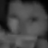

(48, 48)
Happy
[[224 161 125 125]]
[[30 22 15 ... 85 84 86]
 [29 19 11 ... 87 85 87]
 [30 21 10 ... 89 86 87]
 ...
 [36 36 37 ... 60 59 58]
 [36 36 37 ... 59 59 58]
 [38 38 39 ... 59 58 59]]
/n/n/n/n/n/n/n


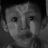

(48, 48)
Neutral
[[223 158 127 127]]
[[28 28 25 ... 85 84 85]
 [27 28 24 ... 86 84 86]
 [29 28 25 ... 88 85 85]
 ...
 [33 34 37 ... 60 60 59]
 [35 37 37 ... 61 61 60]
 [38 38 39 ... 63 63 63]]
/n/n/n/n/n/n/n


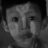

(48, 48)
Neutral
[[225 157 126 126]]
[[28 26 21 ... 86 85 85]
 [27 23 16 ... 88 85 86]
 [27 17 10 ... 90 85 86]
 ...
 [33 36 37 ... 60 59 58]
 [34 37 38 ... 60 60 60]
 [37 38 39 ... 61 60 60]]
/n/n/n/n/n/n/n


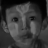

(48, 48)
Neutral
[[226 158 127 127]]
[[29 25 19 ... 86 85 88]
 [26 19 12 ... 87 85 88]
 [28 25 21 ... 90 87 87]
 ...
 [39 39 40 ... 66 66 67]
 [40 41 43 ... 67 67 69]
 [40 40 43 ... 69 71 70]]
/n/n/n/n/n/n/n


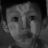

(48, 48)
Neutral
[[228 158 130 130]]
[[26 23 17 ... 93 92 90]
 [23 18 12 ... 92 92 90]
 [25 17 12 ... 90 90 90]
 ...
 [44 46 51 ... 70 75 68]
 [44 46 49 ... 68 75 68]
 [44 46 46 ... 70 73 70]]
/n/n/n/n/n/n/n


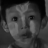

(48, 48)
Neutral
[[228 156 134 134]]
[[37 46 51 ... 92 90 90]
 [32 38 42 ... 89 89 89]
 [29 31 30 ... 89 88 88]
 ...
 [45 46 47 ... 79 68 61]
 [45 47 47 ... 73 68 63]
 [46 47 47 ... 70 67 64]]
/n/n/n/n/n/n/n


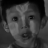

(48, 48)
Neutral
[[234 158 126 126]]
[[11  8  6 ... 90 90 90]
 [ 9  7  8 ... 89 90 90]
 [11  9  6 ... 88 89 89]
 ...
 [49 49 47 ... 63 65 72]
 [49 49 47 ... 64 66 74]
 [50 50 50 ... 65 68 78]]
/n/n/n/n/n/n/n


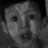

(48, 48)
Neutral
[[236 156 126 126]]
[[13 10  8 ... 94 93 90]
 [11  9  5 ... 92 92 92]
 [ 9  6  3 ... 90 90 90]
 ...
 [44 44 45 ... 62 61 61]
 [46 46 47 ... 61 63 65]
 [47 49 49 ... 63 64 71]]
/n/n/n/n/n/n/n


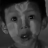

(48, 48)
Neutral
[[235 153 128 128]
 [527 258  54  54]]
[[66 54 41 ... 89 92 94]
 [54 40 26 ... 95 94 93]
 [46 37 22 ... 95 94 93]
 ...
 [43 43 43 ... 59 57 57]
 [44 44 45 ... 63 61 61]
 [46 46 47 ... 61 63 65]]
/n/n/n/n/n/n/n


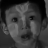

(48, 48)
Sad
[[26 25 23 ...  0  1  0]
 [25 24 24 ...  0  1  0]
 [25 24 23 ...  1  1  0]
 ...
 [79 84 87 ... 47 49 51]
 [84 88 92 ... 46 49 51]
 [87 89 93 ... 47 50 52]]
/n/n/n/n/n/n/n


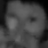

(48, 48)
Happy
[[235 151 133 133]
 [526 258  53  53]]
[[73 72 73 ... 94 94 92]
 [73 71 71 ... 92 92 90]
 [68 68 61 ... 92 92 90]
 ...
 [49 47 49 ... 60 56 57]
 [49 49 49 ... 64 57 58]
 [50 50 50 ... 70 59 57]]
/n/n/n/n/n/n/n


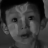

(48, 48)
Neutral
[[ 25  26  25 ...   2   2   1]
 [ 25  25  24 ...   2   2   0]
 [ 25  25  24 ...   2   2   1]
 ...
 [100  90  78 ...  44  45  47]
 [ 97  88  78 ...  44  46  47]
 [ 94  84  84 ...  43  44  46]]
/n/n/n/n/n/n/n


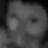

(48, 48)
Happy
[[236 152 132 132]]
[[75 78 75 ... 94 94 94]
 [74 75 68 ... 93 92 92]
 [74 74 63 ... 93 92 92]
 ...
 [46 46 47 ... 65 61 57]
 [47 49 49 ... 71 65 56]
 [49 49 49 ... 73 70 59]]
/n/n/n/n/n/n/n


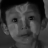

(48, 48)
Neutral
[[237 156 130 130]]
[[66 64 52 ... 94 94 93]
 [60 52 38 ... 94 92 92]
 [52 38 24 ... 94 90 90]
 ...
 [49 49 50 ... 63 67 71]
 [49 49 50 ... 65 68 74]
 [51 51 52 ... 66 70 79]]
/n/n/n/n/n/n/n


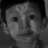

(48, 48)
Neutral
[[239 157 129 129]]
[[46 26 17 ... 95 94 93]
 [35 23 13 ... 94 94 93]
 [37 15  9 ... 94 93 92]
 ...
 [49 50 51 ... 71 72 63]
 [50 51 51 ... 71 75 66]
 [51 52 52 ... 68 75 70]]
/n/n/n/n/n/n/n


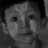

(48, 48)
Neutral
[[237 156 131 131]]
[[60 56 49 ... 95 95 93]
 [54 49 42 ... 95 95 94]
 [47 42 32 ... 94 94 94]
 ...
 [50 50 51 ... 79 73 56]
 [51 51 52 ... 77 78 61]
 [52 52 53 ... 72 82 70]]
/n/n/n/n/n/n/n


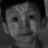

(48, 48)
Neutral
[[239 158 129 129]
 [524 260  53  53]]
[[22 29 15 ... 95 93 92]
 [14 23 11 ... 95 93 90]
 [22 12  8 ... 93 90 87]
 ...
 [51 51 51 ... 81 64 53]
 [52 52 52 ... 82 70 57]
 [53 53 53 ... 80 79 63]]
/n/n/n/n/n/n/n


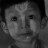

(48, 48)
Neutral
[[ 25  26  22 ...   2   2   2]
 [ 25  26  22 ...   2   2   2]
 [ 25  25  21 ...   2   2   3]
 ...
 [ 82  87  90 ...  43  45  50]
 [ 86  92  99 ...  44  46  50]
 [ 88  96 104 ...  43  46  52]]
/n/n/n/n/n/n/n


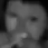

(48, 48)
Happy
[[238 158 130 130]
 [522 260  53  53]]
[[28 30 29 ... 95 93 92]
 [25 24 23 ... 95 93 90]
 [31 21 12 ... 93 90 87]
 ...
 [52 52 52 ... 70 57 57]
 [53 53 53 ... 79 64 59]
 [53 53 53 ... 85 68 59]]
/n/n/n/n/n/n/n


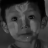

(48, 48)
Neutral
[[25 26 22 ...  2  2  2]
 [25 26 22 ...  2  2  2]
 [25 25 21 ...  2  2  3]
 ...
 [82 84 88 ... 40 44 48]
 [82 87 94 ... 43 45 50]
 [82 90 99 ... 42 44 50]]
/n/n/n/n/n/n/n


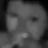

(48, 48)
Happy
[[237 157 131 131]
 [521 260  53  53]]
[[38 37 36 ... 95 94 94]
 [33 32 30 ... 95 93 93]
 [32 29 25 ... 95 93 92]
 ...
 [51 51 51 ... 56 57 60]
 [52 52 52 ... 61 58 61]
 [53 53 53 ... 66 58 61]]
/n/n/n/n/n/n/n


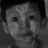

(48, 48)
Neutral
[[ 26  25  22 ...   2   2   2]
 [ 26  25  22 ...   2   2   2]
 [ 25  24  21 ...   3   3   3]
 ...
 [ 82  85  89 ...  42  45  49]
 [ 84  89  96 ...  44  46  50]
 [ 85  93 101 ...  43  45  51]]
/n/n/n/n/n/n/n


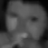

(48, 48)
Happy
[[238 160 128 128]
 [520 259  57  57]]
[[36 26 14 ... 93 93 93]
 [31 21 12 ... 93 93 93]
 [30 18 11 ... 92 91 91]
 ...
 [52 52 52 ... 68 56 57]
 [53 53 52 ... 78 58 59]
 [53 53 52 ... 81 66 60]]
/n/n/n/n/n/n/n


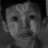

(48, 48)
Neutral
[[26 24 19 ...  1  1  1]
 [25 24 19 ...  2  1  1]
 [25 24 19 ...  2  1  1]
 ...
 [79 83 92 ... 49 47 44]
 [79 86 95 ... 47 46 44]
 [80 89 99 ... 47 46 44]]
/n/n/n/n/n/n/n


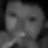

(48, 48)
Happy
[[239 161 127 127]
 [520 261  55  55]]
[[29 12  8 ... 94 93 92]
 [25 12  8 ... 93 93 93]
 [23 11  8 ... 93 93 91]
 ...
 [51 51 51 ... 57 54 57]
 [52 52 52 ... 59 57 59]
 [53 52 52 ... 65 58 60]]
/n/n/n/n/n/n/n


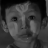

(48, 48)
Neutral
[[ 24  19  14 ...   2   2   1]
 [ 24  19  14 ...   1   1   1]
 [ 24  19  14 ...   1   1   1]
 ...
 [ 79  84  90 ...  53  51  47]
 [ 82  89  98 ...  52  49  46]
 [ 83  93 103 ...  51  47  46]]
/n/n/n/n/n/n/n


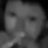

(48, 48)
Happy
[[238 163 127 127]
 [519 263  53  53]]
[[35 28 16 ... 96 94 93]
 [31 25 15 ... 95 94 93]
 [29 21 12 ... 93 93 91]
 ...
 [52 52 52 ... 67 56 58]
 [53 52 52 ... 76 60 59]
 [53 52 53 ... 82 67 59]]
/n/n/n/n/n/n/n


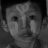

(48, 48)
Neutral
[[25 22 15 ...  2  2  2]
 [25 19 15 ...  1  1  1]
 [25 18 12 ...  1  1  1]
 ...
 [75 79 84 ... 52 52 50]
 [76 79 84 ... 52 52 52]
 [78 81 87 ... 52 52 52]]
/n/n/n/n/n/n/n


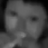

(48, 48)
Happy
[[238 163 130 130]]
[[33 32 21 ... 93 93 93]
 [36 30 19 ... 93 93 91]
 [33 28 18 ... 91 91 91]
 ...
 [52 53 53 ... 61 61 61]
 [53 53 53 ... 64 61 61]
 [53 53 54 ... 65 63 61]]
/n/n/n/n/n/n/n


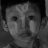

(48, 48)
Neutral
[[237 164 128 128]
 [517 266  53  53]]
[[37 37 33 ... 97 95 94]
 [38 37 31 ... 97 95 94]
 [37 34 27 ... 95 95 94]
 ...
 [53 52 52 ... 59 60 61]
 [53 52 53 ... 63 59 61]
 [54 53 53 ... 70 60 63]]
/n/n/n/n/n/n/n


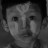

(48, 48)
Neutral
[[25 18 12 ...  1  2  2]
 [24 16 10 ...  1  2  2]
 [19 15  9 ...  2  1  1]
 ...
 [79 80 81 ... 52 52 50]
 [76 79 82 ... 52 51 49]
 [74 78 82 ... 52 47 45]]
/n/n/n/n/n/n/n


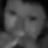

(48, 48)
Happy
[[238 164 127 127]]
[[37 33 23 ... 96 96 96]
 [37 31 22 ... 97 96 95]
 [34 27 18 ... 97 96 95]
 ...
 [52 52 52 ... 57 59 59]
 [52 52 52 ... 58 61 61]
 [52 53 53 ... 59 60 61]]
/n/n/n/n/n/n/n


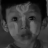

(48, 48)
Neutral
[[238 165 129 129]]
[[38 32 31 ... 96 94 93]
 [36 30 28 ... 96 94 93]
 [33 26 24 ... 96 94 93]
 ...
 [53 53 53 ... 62 61 61]
 [53 53 54 ... 63 63 61]
 [53 54 55 ... 64 64 61]]
/n/n/n/n/n/n/n


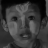

(48, 48)
Happy
[[238 165 130 130]]
[[38 32 31 ... 95 93 93]
 [36 30 28 ... 95 94 94]
 [33 26 24 ... 95 93 93]
 ...
 [53 53 54 ... 63 63 63]
 [53 54 55 ... 64 63 63]
 [54 57 57 ... 64 64 62]]
/n/n/n/n/n/n/n


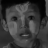

(48, 48)
Fear
[[238 166 127 127]]
[[37 33 29 ... 95 96 97]
 [36 31 26 ... 92 97 98]
 [36 31 23 ... 84 97 98]
 ...
 [53 53 53 ... 57 60 60]
 [53 53 53 ... 59 60 61]
 [53 53 54 ... 63 60 63]]
/n/n/n/n/n/n/n


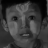

(48, 48)
Neutral
[[239 164 126 126]]
[[ 36  36  29 ... 101  97  97]
 [ 36  32  27 ...  93  96  96]
 [ 32  29  23 ...  87  97  98]
 ...
 [ 52  52  51 ...  55  55  57]
 [ 52  53  52 ...  54  55  54]
 [ 52  53  52 ...  55  57  56]]
/n/n/n/n/n/n/n


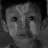

(48, 48)
Neutral
[[239 163 127 127]]
[[ 36  36  30 ... 101  96 101]
 [ 37  34  30 ...  97  96  96]
 [ 33  32  27 ...  96  96  96]
 ...
 [ 53  52  53 ...  55  54  57]
 [ 53  52  53 ...  55  54  57]
 [ 53  53  53 ...  57  56  58]]
/n/n/n/n/n/n/n


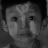

(48, 48)
Neutral
[[240 164 126 126]]
[[33 29 19 ... 97 96 96]
 [31 25 16 ... 94 97 97]
 [29 21 12 ... 87 99 99]
 ...
 [52 54 56 ... 54 57 59]
 [53 54 57 ... 56 58 60]
 [54 56 57 ... 58 60 62]]
/n/n/n/n/n/n/n


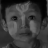

(48, 48)
Neutral
[[239 159 128 128]]
[[ 36  37  35 ...  86  75  70]
 [ 36  36  31 ...  97  94  90]
 [ 37  35  29 ...  97 100 101]
 ...
 [ 53  53  54 ...  57  58  60]
 [ 53  53  56 ...  57  59  60]
 [ 53  53  56 ...  58  60  60]]
/n/n/n/n/n/n/n


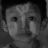

(48, 48)
Neutral
[[239 159 124 124]]
[[ 37  36  30 ...  35  79 106]
 [ 33  32  26 ...  22  61  95]
 [ 31  31  24 ...   9  43  82]
 ...
 [ 50  50  50 ...  59  55  56]
 [ 51  51  51 ...  59  57  56]
 [ 53  52  53 ...  60  57  56]]
/n/n/n/n/n/n/n


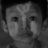

(48, 48)
Neutral
[[237 158 128 128]]
[[ 40  37  37 ... 104  99 100]
 [ 40  37  35 ... 101  97  97]
 [ 39  35  32 ...  96  99  97]
 ...
 [ 52  53  54 ...  55  58  59]
 [ 53  52  54 ...  57  58  60]
 [ 56  54  56 ...  59  60  63]]
/n/n/n/n/n/n/n


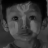

(48, 48)
Neutral
[[236 156 129 129]]
[[ 45  38  36 ... 102  96  94]
 [ 43  38  37 ... 102  99 100]
 [ 42  38  37 ... 100  97  99]
 ...
 [ 53  52  53 ...  55  58  59]
 [ 54  53  52 ...  58  59  60]
 [ 53  56  54 ...  59  60  63]]
/n/n/n/n/n/n/n


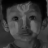

(48, 48)
Neutral
[[238 157 125 125]]
[[34 25 11 ... 73 94 99]
 [32 24 11 ... 59 89 99]
 [29 18 10 ... 45 79 96]
 ...
 [53 53 52 ... 57 56 57]
 [54 56 54 ... 56 56 57]
 [53 56 54 ... 56 56 57]]
/n/n/n/n/n/n/n


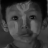

(48, 48)
Neutral
[[236 150 131 131]]
[[53 49 46 ... 67 72 82]
 [46 40 39 ... 74 72 85]
 [40 36 37 ... 87 92 92]
 ...
 [53 56 56 ... 61 61 61]
 [52 54 56 ... 60 63 63]
 [53 54 58 ... 63 63 63]]
/n/n/n/n/n/n/n


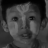

(48, 48)
Neutral
[[238 149 126 126]]
[[ 37  27  10 ...  95  93  90]
 [ 36  24  12 ...  99 100 101]
 [ 32  21  11 ...  97  99 100]
 ...
 [ 51  51  51 ...  56  56  58]
 [ 51  51  52 ...  56  57  59]
 [ 53  53  54 ...  59  60  62]]
/n/n/n/n/n/n/n


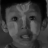

(48, 48)
Neutral
[[167   4  69  69]
 [297 116  82  82]]
[[  5   4   4 ...   2  21  50]
 [  4   4   4 ...   4  14  36]
 [  4   5   5 ...   8   9  23]
 ...
 [111  99 104 ...  59  81  92]
 [114 115 120 ...  34  45  53]
 [134 148 158 ...  23  30  44]]
/n/n/n/n/n/n/n


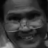

(48, 48)
Happy
[[  7   6  11 ... 128 139 155]
 [  7   6  10 ... 138 141 177]
 [  6   6   9 ... 124 107 166]
 ...
 [113 101  93 ...   8   7   7]
 [131 102  90 ...   9   8   7]
 [122 111  86 ...   9   8   7]]
/n/n/n/n/n/n/n


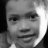

(48, 48)
Happy
[[167   4  69  69]
 [297 115  82  82]]
[[  5   4   4 ...   2  21  50]
 [  4   4   4 ...   4  14  36]
 [  4   5   5 ...   8   9  23]
 ...
 [111  99 104 ...  59  81  92]
 [114 115 120 ...  34  45  53]
 [134 148 158 ...  23  30  44]]
/n/n/n/n/n/n/n


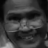

(48, 48)
Happy
[[  7  10  14 ...  99 130 150]
 [  7  10  12 ... 130 148 144]
 [  7   9  10 ... 138 151 177]
 ...
 [ 94  94  90 ...   7   7   5]
 [ 89  88  88 ...   8   7   7]
 [ 85 109  86 ...   9   8   7]]
/n/n/n/n/n/n/n


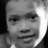

(48, 48)
Happy
[[167   4  69  69]
 [297 116  81  81]]
[[  5   4   4 ...   2  15  43]
 [  4   4   4 ...   4  10  30]
 [  4   5   5 ...   8   9  18]
 ...
 [113 100  99 ...  66  89 100]
 [113 109 114 ...  40  54  63]
 [128 135 145 ...  25  32  45]]
/n/n/n/n/n/n/n


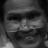

(48, 48)
Happy
[[ 11   8  14 ... 118 136 150]
 [  9   9  14 ... 129 141 159]
 [  7   9  12 ... 131 111 134]
 ...
 [100  94  90 ...   7   7   7]
 [ 89  88  89 ...  10   8   7]
 [ 93  99  84 ...  11   9   8]]
/n/n/n/n/n/n/n


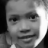

(48, 48)
Happy
[[167   3  69  69]
 [296 115  82  82]]
[[  5   5   5 ...   1   4  31]
 [  5   5   4 ...   3   5  30]
 [  4   4   4 ...   5   5  22]
 ...
 [106  93  92 ...  85 103 108]
 [110  97  97 ...  66  89 100]
 [111 107 111 ...  40  54  63]]
/n/n/n/n/n/n/n


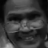

(48, 48)
Happy
[[ 73  73  51 ...  92 114 127]
 [ 74  67  33 ... 108 115 142]
 [ 74  60  28 ... 129 146 160]
 ...
 [115 110 105 ...   7   7   7]
 [114 109 101 ...  10   8   7]
 [130 114  97 ...  11   9   8]]
/n/n/n/n/n/n/n


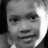

(48, 48)
Happy
[[167   3  69  69]
 [297 115  82  82]]
[[  5   5   5 ...   1   4  31]
 [  5   5   4 ...   3   5  30]
 [  4   4   4 ...   5   5  22]
 ...
 [106  93  92 ...  87 103 106]
 [110  97  97 ...  72  95 104]
 [111 107 111 ...  46  64  73]]
/n/n/n/n/n/n/n


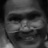

(48, 48)
Happy
[[ 70  42  12 ... 114 127 134]
 [ 60  28  11 ... 115 142 138]
 [ 52  23  11 ... 146 160 164]
 ...
 [111 112 111 ...   7   7   5]
 [110 104 103 ...   8   7   7]
 [110 100  97 ...   9   8   7]]
/n/n/n/n/n/n/n


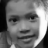

(48, 48)
Happy
[[168   4  69  69]
 [296 114  84  84]]
[[  5   5   5 ...   4  31  57]
 [  5   4   4 ...   5  28  52]
 [  5   5   4 ...   6  16  39]
 ...
 [ 99  97 102 ...  95 104 109]
 [106 108 110 ...  64  73  97]
 [129 137 145 ...  37  47  60]]
/n/n/n/n/n/n/n


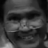

(48, 48)
Happy
[[ 75  59  26 ... 121 121 132]
 [ 68  47  22 ... 127 128 153]
 [ 63  30  15 ... 137 138 144]
 ...
 [122 102  96 ...   7   7   5]
 [138 114 102 ...   8   7   5]
 [109 117 104 ...   8   7   8]]
/n/n/n/n/n/n/n


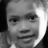

(48, 48)
Happy
[[168   3  69  69]
 [296 116  82  82]]
[[  5   5   5 ...   5  35  63]
 [  5   5   5 ...   4  31  57]
 [  5   4   4 ...   5  28  52]
 ...
 [ 94  94  97 ...  99 100 101]
 [ 97  97 102 ... 100 111 109]
 [104 106 108 ...  73  86  97]]
/n/n/n/n/n/n/n


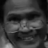

(48, 48)
Happy
[[ 35  18  10 ...  93 116 136]
 [ 23  11   9 ... 113 139 159]
 [ 10   9   8 ... 134 128 148]
 ...
 [106  99  93 ...   9   8   7]
 [118 101  94 ...  11   9   8]
 [121 109  95 ...  11   9   8]]
/n/n/n/n/n/n/n


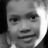

(48, 48)
Happy
[[168   3  69  69]
 [297 116  82  82]]
[[  5   5   5 ...   3  26  57]
 [  5   5   5 ...   2  23  51]
 [  5   4   4 ...   4  21  47]
 ...
 [ 94  94  97 ...  99 100 101]
 [ 97  97 102 ... 100 111 109]
 [104 106 108 ...  73  86  97]]
/n/n/n/n/n/n/n


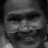

(48, 48)
Happy
[[ 18  10   9 ... 116 136 144]
 [ 11   9   9 ... 139 159 145]
 [  9   8   9 ... 128 148 171]
 ...
 [ 99  93  96 ...   8   7   5]
 [101  94  89 ...   9   8   7]
 [109  95  86 ...   9   8   8]]
/n/n/n/n/n/n/n


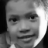

(48, 48)
Happy
[[169   4  69  69]
 [297 116  82  82]]
[[  5   5   5 ...   9  37  63]
 [  5   4   5 ...   9  35  58]
 [  5   4   5 ...   7  22  45]
 ...
 [ 99 103 110 ... 107 110 107]
 [107 110 120 ...  87  95 103]
 [135 144 151 ...  47  59  79]]
/n/n/n/n/n/n/n


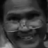

(48, 48)
Happy
[[ 18  10   9 ... 115 128 135]
 [ 11   9   9 ... 129 144 134]
 [  8   8   9 ... 138 158 162]
 ...
 [104  94  93 ...   8   7   5]
 [114  97  92 ...   9   8   7]
 [114 101  89 ...   9   8   8]]
/n/n/n/n/n/n/n


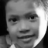

(48, 48)
Happy
[[169   4  69  69]
 [295 116  83  83]]
[[  7   5   5 ...   2  23  52]
 [  7   5   5 ...   4  22  50]
 [  6   4   4 ...   4  15  38]
 ...
 [ 99 102 109 ... 106 109 106]
 [107 109 117 ...  95 102 106]
 [132 143 149 ...  57  68  87]]
/n/n/n/n/n/n/n


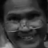

(48, 48)
Happy
[[ 77  54  25 ... 107 131 129]
 [ 77  39  19 ... 114 129 139]
 [ 74  27  13 ... 130 144 159]
 ...
 [ 42  14  65 ...  10   8   8]
 [ 38  18  33 ...  10   8   8]
 [ 36  28  23 ...  11   9   9]]
/n/n/n/n/n/n/n


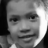

(48, 48)
Happy
[[170   4  69  69]
 [294 116  85  85]]
[[  7   5   5 ...   9  40  67]
 [  7   5   5 ...   9  37  63]
 [  5   4   5 ...   9  32  57]
 ...
 [101 108 116 ... 103 102 102]
 [107 115 124 ... 110 108 108]
 [129 135 150 ...  87 100 108]]
/n/n/n/n/n/n/n


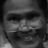

(48, 48)
Happy
[[ 82  79  71 ... 126 100 138]
 [ 82  79  65 ... 143 137 152]
 [ 82  80  53 ... 131 144 128]
 ...
 [ 25  36  38 ...   9   9  10]
 [ 30  37  37 ...   9   9  10]
 [ 32  38  38 ...  11  11  10]]
/n/n/n/n/n/n/n


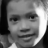

(48, 48)
Happy
[[169   4  69  69]
 [293 114  87  87]]
[[  7   7   5 ...   1   9  40]
 [  7   7   5 ...   1   9  37]
 [  6   5   4 ...   4   9  32]
 ...
 [ 97 102 109 ...  99 100 101]
 [103 107 115 ... 108 110 107]
 [118 123 132 ...  88  99 107]]
/n/n/n/n/n/n/n


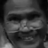

(48, 48)
Happy
[[ 81  79  75 ... 139 181 173]
 [ 84  81  78 ... 130 137 180]
 [ 86  82  79 ... 105 132 165]
 ...
 [ 28  29  35 ...   9  10   8]
 [ 26  28  32 ...   9  10  10]
 [ 26  28  31 ...  11  10  10]]
/n/n/n/n/n/n/n


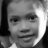

(48, 48)
Happy
[[168   5  71  71]
 [296 114  87  87]]
[[  8   7   7 ...  16  47  70]
 [  9   8   7 ...  16  44  65]
 [  6   6   5 ...  14  36  57]
 ...
 [137 151 160 ...  70  86  95]
 [164 180 191 ...  45  54  66]
 [184 194 198 ...  43  43  50]]
/n/n/n/n/n/n/n


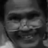

(48, 48)
Neutral
[[ 80  77  46 ... 158 109  93]
 [ 77  58  23 ... 165 157  73]
 [ 71  44  15 ... 187 160 117]
 ...
 [ 52  57 100 ...   8  15  24]
 [ 52  36  59 ...   8  23  42]
 [ 46  37  19 ...  10  23  45]]
/n/n/n/n/n/n/n


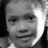

(48, 48)
Happy
[[168   5  71  71]
 [295 116  85  85]]
[[  8   7   7 ...  25  57  73]
 [  9   8   7 ...  23  51  70]
 [  8   8   5 ...  21  45  64]
 ...
 [130 143 151 ...  70  86  95]
 [158 174 185 ...  45  54  66]
 [179 192 198 ...  43  43  50]]
/n/n/n/n/n/n/n


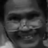

(48, 48)
Neutral
[[ 78  63  32 ... 123 135 187]
 [ 75  53  25 ... 128 142 181]
 [ 73  37  17 ... 139 143 186]
 ...
 [ 45  78 115 ...  10  10   8]
 [ 51  19  46 ...  10  11   9]
 [ 60  40  33 ...  11  10  10]]
/n/n/n/n/n/n/n


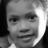

(48, 48)
Happy
[[165   5  73  73]
 [295 117  82  82]]
[[ 10   9   8 ...   7  36  65]
 [  9   8   8 ...   7  30  58]
 [  8   8   7 ...   8  29  52]
 ...
 [121 128 149 ...  38  42  44]
 [124 143 171 ...  42  52  51]
 [122 151 184 ...  39  56  60]]
/n/n/n/n/n/n/n


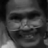

(48, 48)
Happy
[[ 43  19  12 ... 131 149 113]
 [ 39  15  10 ...  90 122 135]
 [ 32  10  10 ... 103 123 145]
 ...
 [117 115 103 ...   9   7   7]
 [131 115 102 ...   9   8   7]
 [ 94 120 108 ...  10   8   8]]
/n/n/n/n/n/n/n


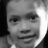

(48, 48)
Happy
[[164   4  76  76]
 [295 119  80  80]]
[[ 12  10   9 ...  80  79  78]
 [ 12  10   8 ...  72  77  79]
 [ 10  10   9 ...  64  75  81]
 ...
 [120 115 139 ...  59  56  56]
 [123 122 153 ...  56  59  61]
 [158 155 177 ...  42  53  61]]
/n/n/n/n/n/n/n


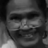

(48, 48)
Happy
[[ 19  10  10 ... 108  97 108]
 [ 10   8   8 ... 114 116 120]
 [ 10   8   8 ... 116 128 123]
 ...
 [110 103 100 ...  12   9   8]
 [115 102  99 ...  14  10   8]
 [116 101  93 ...  15  11   8]]
/n/n/n/n/n/n/n


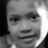

(48, 48)
Happy
[[165   4  76  76]
 [295 118  82  82]]
[[ 10  10   9 ...  79  78  82]
 [ 10   8   9 ...  77  79  81]
 [ 10   9   8 ...  75  81  82]
 ...
 [115 136 177 ...  56  56  53]
 [120 150 192 ...  59  61  60]
 [144 171 203 ...  53  61  60]]
/n/n/n/n/n/n/n


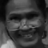

(48, 48)
Sad
[[ 33  15  11 ... 113 124 118]
 [ 26  11   9 ... 111 138 144]
 [ 18   9   9 ... 132 136 174]
 ...
 [101  93  90 ...   8   7   7]
 [106  93  88 ...   8   8   8]
 [123  94  86 ...   8   8   9]]
/n/n/n/n/n/n/n


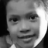

(48, 48)
Happy
[[167   4  75  75]
 [296 119  80  80]]
[[  9   9   8 ...  78  82  81]
 [  9   9   8 ...  78  82  81]
 [  9   9   8 ...  80  81  81]
 ...
 [150 178 193 ...  54  45  40]
 [172 193 199 ...  54  51  40]
 [188 200 202 ...  59  59  50]]
/n/n/n/n/n/n/n


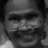

(48, 48)
Happy
[[ 29  15  12 ...  86 111 151]
 [ 19  12  12 ... 111 128 150]
 [ 14  10  10 ... 127 130 138]
 ...
 [ 97  97 100 ...   8   7   8]
 [100  97  93 ...   9   8   8]
 [ 94  92  87 ...  10   8   7]]
/n/n/n/n/n/n/n


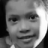

(48, 48)
Happy
[[167   5  74  74]
 [291 117  84  84]]
[[  9   9   8 ...  78  78  82]
 [  9   9   8 ...  74  80  81]
 [  8   8   7 ...  72  80  81]
 ...
 [158 174 189 ...  57  54  46]
 [179 189 198 ...  52  54  46]
 [193 199 201 ...  58  59  56]]
/n/n/n/n/n/n/n


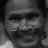

(48, 48)
Neutral
[[ 89  85  81 ... 145 156 111]
 [ 88  85  82 ... 127 156 158]
 [ 89  86  84 ...  96 100 120]
 ...
 [105 137 134 ...  11   9   8]
 [ 75 132 124 ...  11   9   8]
 [ 53 108 129 ...  14   9   8]]
/n/n/n/n/n/n/n


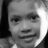

(48, 48)
Happy
[[166   4  76  76]
 [292 119  82  82]]
[[ 10   9   9 ...  78  81  79]
 [  9   9   9 ...  78  82  81]
 [  9   9   9 ...  79  81  81]
 ...
 [139 174 189 ...  54  43  38]
 [155 191 199 ...  58  52  42]
 [171 201 202 ...  63  56  49]]
/n/n/n/n/n/n/n


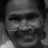

(48, 48)
Happy
[[ 84  82  72 ... 106 108 114]
 [ 85  82  70 ... 100  86 116]
 [ 84  81  74 ... 114 111 129]
 ...
 [150 141 128 ...  12  11   9]
 [148 149 136 ...  12  11   9]
 [ 65 121 143 ...  15  10   8]]
/n/n/n/n/n/n/n


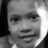

(48, 48)
Happy
[[163   5  77  77]
 [294 119  83  83]]
[[ 15  12  10 ...  78  81  78]
 [ 14  12  10 ...  70  78  78]
 [ 11  11  10 ...  58  74  80]
 ...
 [127 125 137 ...  59  59  60]
 [149 159 164 ...  47  58  63]
 [187 199 198 ...  39  47  54]]
/n/n/n/n/n/n/n


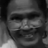

(48, 48)
Sad
[[ 51  22  11 ...  97 110 150]
 [ 44  12  10 ... 136 132 152]
 [ 37   7  10 ... 159 153 142]
 ...
 [123 114 100 ...  10   8   8]
 [ 84 116 108 ...  10  10   9]
 [ 56  85 111 ...   9  11  11]]
/n/n/n/n/n/n/n


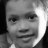

(48, 48)
Happy
[[165   6  76  76]
 [290 119  83  83]]
[[ 10   9   9 ...  79  79  78]
 [ 10   9   9 ...  75  78  80]
 [  9   9   9 ...  73  80  80]
 ...
 [137 177 201 ...  58  59  53]
 [164 192 206 ...  60  63  58]
 [198 203 208 ...  54  60  64]]
/n/n/n/n/n/n/n


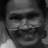

(48, 48)
Sad
[[ 85  82  77 ... 107 129 135]
 [ 84  81  64 ...  90  93 125]
 [ 85  78  53 ... 104 114 135]
 ...
 [102 124 128 ...  11   9  10]
 [ 33  71 103 ...  17  10   9]
 [ 35  17  24 ...  18  12  10]]
/n/n/n/n/n/n/n


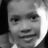

(48, 48)
Happy
[[165   6  76  76]
 [291 120  82  82]]
[[ 10   9   9 ...  80  79  77]
 [ 10   9   9 ...  77  78  79]
 [ 10   9  10 ...  74  79  80]
 ...
 [132 171 200 ...  51  54  47]
 [163 194 205 ...  60  58  53]
 [192 203 208 ...  60  63  58]]
/n/n/n/n/n/n/n


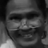

(48, 48)
Angry 
[[ 74  44  13 ...  96 128 142]
 [ 64  26   7 ... 120 134 159]
 [ 54  19   6 ... 128 117 153]
 ...
 [121 114 100 ...  12   9   8]
 [120  97  96 ...  14  10   8]
 [116 121 106 ...  16  11   9]]
/n/n/n/n/n/n/n


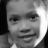

(48, 48)
Happy
[[165   6  77  77]
 [288 119  83  83]]
[[ 10   9   9 ...  79  75  73]
 [ 10   9   9 ...  78  78  74]
 [ 10  10  10 ...  78  80  76]
 ...
 [155 188 203 ...  57  50  45]
 [186 202 208 ...  60  56  44]
 [207 207 208 ...  64  61  38]]
/n/n/n/n/n/n/n


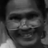

(48, 48)
Sad
[[ 89  86  85 ...  89 109 113]
 [ 88  85  81 ...  92 104 134]
 [ 87  84  73 ... 113 122 141]
 ...
 [175 144 123 ...  12   9   8]
 [112 133 139 ...  19  10   8]
 [ 38  72 102 ...  29  12   8]]
/n/n/n/n/n/n/n


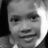

(48, 48)
Happy
[[164   6  77  77]
 [290 117  86  86]]
[[ 11  10   9 ...  81  78  75]
 [ 11  10   9 ...  79  79  77]
 [ 11  10  10 ...  77  78  80]
 ...
 [123 136 178 ...  56  57  50]
 [162 172 199 ...  61  60  56]
 [198 199 206 ...  57  64  61]]
/n/n/n/n/n/n/n


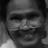

(48, 48)
Happy
[[ 78  52  19 ... 180 152  79]
 [ 77  44  12 ... 205 179 116]
 [ 73  38  10 ... 181 179 177]
 ...
 [ 59  97 129 ...  10  11   8]
 [ 31  49  95 ...  10  10   9]
 [ 23  23  59 ...  10  10   9]]
/n/n/n/n/n/n/n


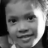

(48, 48)
Happy
[[164   6  78  78]
 [290 121  82  82]]
[[ 12  10   9 ...  78  75  71]
 [ 11  10   9 ...  79  75  73]
 [ 11  10  10 ...  79  79  75]
 ...
 [141 162 195 ...  59  49  46]
 [184 192 206 ...  65  50  36]
 [208 207 208 ...  57  46  31]]
/n/n/n/n/n/n/n


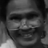

(48, 48)
Sad
[[ 26   8  16 ... 149 130 179]
 [ 17   9  14 ... 180 163 189]
 [  9   8  11 ... 180 165 175]
 ...
 [ 39  69 109 ...   8   9  10]
 [ 29  34  61 ...   9  11  10]
 [ 28  21  29 ...  10  15  11]]
/n/n/n/n/n/n/n


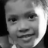

(48, 48)
Happy
[[164   6  77  77]
 [289 120  83  83]]
[[ 12  11   9 ...  80  78  74]
 [ 12  10   9 ...  80  78  75]
 [ 11  10  10 ...  80  79  78]
 ...
 [117 157 198 ...  49  39  30]
 [138 172 202 ...  59  53  43]
 [177 195 207 ...  65  57  38]]
/n/n/n/n/n/n/n


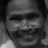

(48, 48)
Happy
[[ 43  11  17 ... 130 174 172]
 [ 36  10  16 ... 118 198 206]
 [ 26   8  16 ... 139 181 215]
 ...
 [ 80  97 112 ...   9   9  10]
 [ 67  66  85 ...  11  10  10]
 [ 65  57  58 ...  14  11  10]]
/n/n/n/n/n/n/n


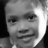

(48, 48)
Happy
[[162   6  77  77]
 [285 122  83  83]]
[[ 10  10  11 ...  80  81  78]
 [ 11  11  10 ...  81  81  78]
 [ 11  11  11 ...  81  81  78]
 ...
 [117 114 134 ...  42  45  44]
 [122 122 153 ...  54  53  53]
 [149 153 178 ...  60  63  63]]
/n/n/n/n/n/n/n


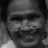

(48, 48)
Neutral
[[108  99  89 ... 103 128 150]
 [107  99  85 ... 102 106 165]
 [104 100  80 ...  93  81 145]
 ...
 [ 15  19  49 ...  33  22  16]
 [ 18  16  46 ...  43  31  23]
 [ 24  23  42 ...  50  38  31]]
/n/n/n/n/n/n/n


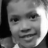

(48, 48)
Happy
[[163   7  77  77]
 [285 123  82  82]]
[[ 11  10   9 ...  79  77  75]
 [ 11   9   9 ...  79  77  75]
 [ 11  11   9 ...  79  78  77]
 ...
 [122 153 194 ...  51  50  39]
 [153 178 202 ...  61  59  47]
 [192 201 209 ...  65  66  47]]
/n/n/n/n/n/n/n


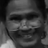

(48, 48)
Happy
[[104  97  80 ...  88 106 124]
 [103  96  73 ... 107  99 100]
 [104  99  65 ... 114  95  80]
 ...
 [ 45  43  60 ...  36  22  15]
 [ 61  66  56 ...  45  30  23]
 [ 46  75  77 ...  52  39  32]]
/n/n/n/n/n/n/n


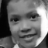

(48, 48)
Happy
[[162   7  77  77]
 [285 122  83  83]]
[[ 11  10  10 ...  79  76  75]
 [ 11   9  10 ...  81  77  77]
 [ 11  11  10 ...  80  78  78]
 ...
 [112 124 166 ...  46  50  45]
 [130 145 185 ...  59  59  54]
 [171 180 200 ...  61  67  63]]
/n/n/n/n/n/n/n


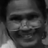

(48, 48)
Happy
[[102  95  70 ... 106 115 128]
 [101  90  60 ... 101 135 130]
 [ 99  85  36 ... 113 121 172]
 ...
 [ 36  29  58 ...  14  12  11]
 [ 57  38  18 ...  16  14  10]
 [ 73  51  43 ...  20  15  12]]
/n/n/n/n/n/n/n


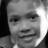

(48, 48)
Happy
[[162   7  78  78]
 [286 122  84  84]]
[[ 11  11   8 ...  74  73  73]
 [ 11   9  10 ...  76  75  74]
 [ 11  10  10 ...  77  77  75]
 ...
 [123 139 181 ...  54  47  38]
 [160 172 196 ...  65  56  40]
 [198 201 207 ...  68  60  35]]
/n/n/n/n/n/n/n


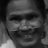

(48, 48)
Happy
[[ 93  65  12 ...  97 117 146]
 [ 88  57   9 ... 141 139 168]
 [ 79  37   6 ... 133 121 167]
 ...
 [ 31  29  88 ...   9   9   9]
 [ 43  33  19 ...  11  10   9]
 [ 52  43  18 ...  12  11  11]]
/n/n/n/n/n/n/n


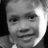

(48, 48)
Happy
[[162   7  78  78]
 [286 122  84  84]]
[[ 11  11   8 ...  74  73  73]
 [ 11   9  10 ...  76  75  74]
 [ 11  10  10 ...  77  77  75]
 ...
 [121 137 186 ...  54  47  38]
 [156 167 201 ...  65  56  40]
 [198 201 207 ...  68  60  35]]
/n/n/n/n/n/n/n


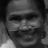

(48, 48)
Happy
[[ 93  65  12 ...  97 117 146]
 [ 88  57   9 ... 141 139 168]
 [ 79  37   6 ... 133 121 167]
 ...
 [ 31  29  88 ...   9   9   9]
 [ 43  33  19 ...  11  10   9]
 [ 52  43  18 ...  12  11  11]]
/n/n/n/n/n/n/n


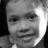

(48, 48)
Happy
[[162   7  78  78]
 [284 123  83  83]]
[[ 10   8   5 ...  73  71  70]
 [  9   8   7 ...  76  74  74]
 [  9   8   7 ...  77  77  75]
 ...
 [114 139 188 ...  50  40  30]
 [136 160 202 ...  60  52  42]
 [180 191 208 ...  68  59  37]]
/n/n/n/n/n/n/n


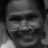

(48, 48)
Happy
[[106 100  92 ...  86 111 130]
 [103  97  74 ...  97 127 134]
 [103  92  56 ... 103 111 151]
 ...
 [ 53  64  46 ...  12  12   9]
 [ 42  40  42 ...  14  12   9]
 [ 35  36  36 ...  17  14  11]]
/n/n/n/n/n/n/n


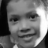

(48, 48)
Happy
[[161   6  80  80]
 [284 122  83  83]]
[[ 11   8   5 ...  70  67  66]
 [ 11   9   7 ...  68  68  67]
 [ 11  10   8 ...  72  72  69]
 ...
 [122 123 155 ...  46  40  50]
 [148 152 171 ...  52  39  53]
 [188 195 201 ...  53  35  51]]
/n/n/n/n/n/n/n


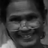

(48, 48)
Happy
[[106 101  95 ... 151  90 102]
 [106 100  92 ...  99 124 132]
 [103  97  74 ... 114 136 123]
 ...
 [ 30  45  45 ...  10   7   8]
 [ 30  38  36 ...  11   9   8]
 [ 29  35  35 ...  11  10   9]]
/n/n/n/n/n/n/n


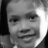

(48, 48)
Happy
[[161   6  80  80]
 [283 124  82  82]]
[[ 11   8   5 ...  72  70  64]
 [ 11   9   7 ...  71  67  65]
 [ 11  10   8 ...  68  67  67]
 ...
 [116 127 167 ...  38  42  44]
 [131 143 184 ...  44  45  59]
 [173 179 198 ...  42  39  64]]
/n/n/n/n/n/n/n


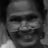

(48, 48)
Happy
[[109 103 100 ...  70  80 120]
 [108 103  93 ...  95  96 107]
 [107 102  84 ... 115 100  94]
 ...
 [ 28  29  29 ...  14  12   9]
 [ 28  28  28 ...  17  12  11]
 [ 26  28  28 ...  19  14  14]]
/n/n/n/n/n/n/n


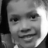

(48, 48)
Happy
[[161   7  80  80]
 [284 124  82  82]]
[[ 11   9   7 ...  72  70  64]
 [ 11  10   8 ...  71  67  66]
 [ 11  10   8 ...  68  68  68]
 ...
 [127 148 189 ...  42  52  56]
 [164 173 199 ...  37  52  67]
 [201 203 206 ...  37  53  72]]
/n/n/n/n/n/n/n


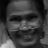

(48, 48)
Happy
[[104 103  84 ...  79 124 132]
 [103  96  61 ...  93 110 137]
 [102  85  43 ... 100  99 148]
 ...
 [ 29  29  32 ...  12   9   7]
 [ 29  29  31 ...  12  10   8]
 [ 28  26  31 ...  14  12  10]]
/n/n/n/n/n/n/n


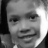

(48, 48)
Happy
[[160   7  81  81]
 [285 126  80  80]]
[[ 12  11   9 ...  71  68  64]
 [ 12  11  10 ...  71  68  65]
 [ 12  11  10 ...  68  68  67]
 ...
 [150 157 181 ...  43  63  59]
 [189 196 200 ...  40  64  71]
 [209 213 210 ...  50  72  80]]
/n/n/n/n/n/n/n


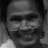

(48, 48)
Happy
[[ 81  38  10 ... 103  99 106]
 [ 73  27   9 ... 117 103  88]
 [ 74  27   9 ... 113 111  79]
 ...
 [ 30  43  58 ...  12  11   9]
 [ 30  43  51 ...  14  12   9]
 [ 30  38  45 ...  17  12  11]]
/n/n/n/n/n/n/n


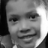

(48, 48)
Happy
[[159   8  79  79]
 [285 125  82  82]]
[[ 12  10  10 ...  78  74  71]
 [ 13  10  10 ...  77  74  70]
 [ 13  11  10 ...  79  76  72]
 ...
 [121 120 141 ...  56  43  38]
 [137 142 160 ...  65  51  40]
 [177 183 192 ...  72  53  36]]
/n/n/n/n/n/n/n


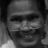

(48, 48)
Neutral
[[ 97  61  18 ... 118 123 122]
 [ 85  40  11 ... 121 148 122]
 [ 68  25  10 ...  93 143 166]
 ...
 [ 56  65  64 ...  10   8   8]
 [ 47  64  66 ...  12  10  10]
 [ 42  59  61 ...  15  12  11]]
/n/n/n/n/n/n/n


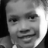

(48, 48)
Happy
[[158   9  78  78]
 [284 124  84  84]]
[[ 15  12  10 ...  80  78  75]
 [ 13  13  11 ...  80  80  78]
 [ 13  12  10 ...  77  81  79]
 ...
 [122 121 123 ...  46  51  47]
 [127 132 141 ...  59  60  57]
 [158 169 178 ...  57  67  65]]
/n/n/n/n/n/n/n


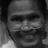

(48, 48)
Neutral
[[106  94  50 ...  99 117 135]
 [104  84  37 ... 116 125 159]
 [ 97  64  19 ... 138 114 142]
 ...
 [ 45  41  35 ...  10  10   9]
 [ 63  44  29 ...  12  11  11]
 [ 63  54  37 ...  12  11  11]]
/n/n/n/n/n/n/n


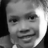

(48, 48)
Happy
[[160  10  77  77]
 [285 127  81  81]]
[[ 10  10   8 ...  79  77  73]
 [ 10   9   8 ...  81  79  76]
 [ 10   9   8 ...  81  78  78]
 ...
 [130 170 203 ...  50  44  35]
 [143 187 213 ...  57  53  43]
 [168 200 215 ...  67  59  42]]
/n/n/n/n/n/n/n


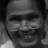

(48, 48)
Happy
[[ 28   8  15 ... 101 138 146]
 [ 18  10  16 ...  87 123 179]
 [ 10  12  15 ...  88  99 170]
 ...
 [113 101 100 ...  12  11  10]
 [ 86  97 104 ...  15  13  10]
 [ 46  70 106 ...  17  14  10]]
/n/n/n/n/n/n/n


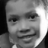

(48, 48)
Happy
[[160  10  78  78]
 [285 128  80  80]]
[[ 10   9   7 ...  75  72  70]
 [ 10   9   7 ...  78  75  73]
 [  9   8   7 ...  78  78  74]
 ...
 [159 202 213 ...  48  39  42]
 [176 213 214 ...  54  40  50]
 [196 213 214 ...  54  38  51]]
/n/n/n/n/n/n/n


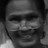

(48, 48)
Happy
[[ 17  11  17 ... 113  90 128]
 [ 12  14  16 ... 122  87 104]
 [ 10  14  14 ... 125 101  90]
 ...
 [102 100 104 ...  14  12  11]
 [101 101 100 ...  16  15  11]
 [ 97 103  93 ...  17  17  13]]
/n/n/n/n/n/n/n


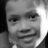

(48, 48)
Happy
[[158   9  80  80]
 [286 127  83  83]]
[[ 11  10   9 ...  79  75  71]
 [ 10  10   9 ...  79  77  72]
 [ 11  10   9 ...  80  77  74]
 ...
 [124 130 182 ...  52  38  49]
 [155 162 191 ...  54  40  58]
 [205 206 207 ...  60  38  59]]
/n/n/n/n/n/n/n


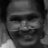

(48, 48)
Happy
[[ 16  16  16 ... 151 186 175]
 [ 15  15  15 ... 137 174 196]
 [ 12  12  14 ... 168 195 220]
 ...
 [ 94  92  88 ...   8   8   8]
 [ 87  85  82 ...   9   8   8]
 [ 84  82  78 ...   9   8   8]]
/n/n/n/n/n/n/n


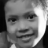

(48, 48)
Happy
[[158   9  80  80]
 [286 128  81  81]]
[[ 11   9   9 ...  79  74  68]
 [ 10  10   9 ...  79  75  70]
 [ 11   9   9 ...  80  77  72]
 ...
 [116 135 181 ...  46  39  47]
 [135 152 194 ...  49  44  59]
 [184 189 201 ...  53  43  65]]
/n/n/n/n/n/n/n


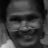

(48, 48)
Happy
[[ 15  15  16 ... 142 136 145]
 [ 14  14  15 ... 123 173 144]
 [ 12  12  12 ... 118 184 167]
 ...
 [ 87  86  84 ...   9   8   8]
 [ 82  82  80 ...  10   8   8]
 [ 80  79  78 ...  11   9   8]]
/n/n/n/n/n/n/n


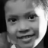

(48, 48)
Happy
[[159  11  78  78]
 [285 128  82  82]]
[[  9   9   9 ...  80  79  73]
 [ 10   9   8 ...  80  79  74]
 [ 10   9   8 ...  79  79  75]
 ...
 [148 193 203 ...  51  37  37]
 [165 206 208 ...  54  42  50]
 [184 207 209 ...  59  44  53]]
/n/n/n/n/n/n/n


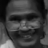

(48, 48)
Happy
[[ 32  19  15 ... 146 124 154]
 [ 19  17  15 ... 150 152 142]
 [ 15  12  12 ... 143 177 156]
 ...
 [107 101  85 ...   9   8   8]
 [ 78 104  86 ...  10   8   8]
 [ 71  99  85 ...  10   8   8]]
/n/n/n/n/n/n/n


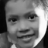

(48, 48)
Happy
[[158  11  79  79]
 [284 128  82  82]]
[[ 10   9   9 ...  80  77  71]
 [ 10   9   9 ...  80  77  72]
 [ 10  10   8 ...  80  78  73]
 ...
 [131 182 208 ...  50  43  50]
 [152 194 212 ...  53  44  58]
 [189 201 209 ...  56  44  59]]
/n/n/n/n/n/n/n


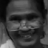

(48, 48)
Happy
[[ 66  31  19 ... 142 124 132]
 [ 72  23  18 ... 137 155 135]
 [ 50  16  16 ... 129 166 159]
 ...
 [ 37  94 137 ...  10   8   8]
 [ 37  28  84 ...  11  10   8]
 [ 37  26  59 ...  11  10   8]]
/n/n/n/n/n/n/n


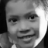

(48, 48)
Happy
[[156   9  81  81]
 [283 128  82  82]]
[[ 11  11  10 ...  77  71  66]
 [ 11  11  10 ...  79  72  66]
 [ 11  11  10 ...  79  74  68]
 ...
 [118 114 141 ...  43  43  46]
 [127 128 157 ...  45  50  60]
 [167 171 182 ...  47  50  68]]
/n/n/n/n/n/n/n


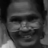

(48, 48)
Neutral
[[ 96  47  19 ... 144 124 113]
 [ 95  36  15 ... 123 151 137]
 [ 72  23  12 ... 121 151 162]
 ...
 [ 36  31  23 ...  11  10   8]
 [ 36  37  38 ...  12  11   9]
 [ 36  37  36 ...  14  11  10]]
/n/n/n/n/n/n/n


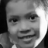

(48, 48)
Happy
[[156  11  81  81]
 [283 130  80  80]]
[[ 11  11   9 ...  77  71  66]
 [ 11  11   9 ...  77  72  70]
 [ 12  10  10 ...  78  73  70]
 ...
 [167 171 182 ...  45  56  68]
 [207 211 208 ...  44  54  75]
 [214 215 213 ...  39  59  84]]
/n/n/n/n/n/n/n


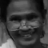

(48, 48)
Happy
[[ 23  11  14 ... 109 107 130]
 [ 19  10  12 ... 121 118 124]
 [ 17  11  11 ... 122 110 109]
 ...
 [ 36  54  31 ...  14  12  11]
 [ 36  36  32 ...  18  14  11]
 [ 33  33  31 ...  22  17  11]]
/n/n/n/n/n/n/n


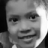

(48, 48)
Happy
[[156  11  81  81]
 [282 130  81  81]]
[[ 11  11  10 ...  75  70  66]
 [ 11  11   9 ...  75  72  70]
 [ 11  11  10 ...  77  72  70]
 ...
 [144 150 178 ...  45  54  59]
 [192 195 199 ...  45  56  71]
 [214 216 213 ...  43  56  78]]
/n/n/n/n/n/n/n


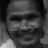

(48, 48)
Happy
[[ 57  16  14 ...  89 123 129]
 [ 40  11  11 ... 123 123 130]
 [ 36  11  11 ... 129 106 116]
 ...
 [ 35  36  36 ...  17  14  11]
 [ 33  33  33 ...  21  15  11]
 [ 33  32  32 ...  23  18  12]]
/n/n/n/n/n/n/n


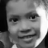

(48, 48)
Happy
[[156  11  81  81]
 [282 130  81  81]]
[[ 11  11  10 ...  75  68  65]
 [ 11  11   9 ...  75  71  68]
 [ 11  11   9 ...  75  72  70]
 ...
 [135 155 193 ...  49  52  43]
 [182 188 201 ...  52  66  54]
 [213 213 209 ...  51  71  68]]
/n/n/n/n/n/n/n


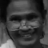

(48, 48)
Happy
[[ 87  44  12 ... 102 136 141]
 [ 78  37  11 ... 117 120 152]
 [ 77  31  10 ... 132 111 136]
 ...
 [ 36  36  36 ...  16  12  11]
 [ 35  35  35 ...  18  12  10]
 [ 34  34  33 ...  21  15  11]]
/n/n/n/n/n/n/n


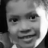

(48, 48)
Happy
[[154  11  82  82]
 [282 131  80  80]]
[[ 11  11  11 ...  79  74  67]
 [ 11  12  11 ...  79  75  70]
 [ 12  12  11 ...  79  75  72]
 ...
 [153 157 167 ...  50  61  56]
 [196 202 206 ...  49  66  68]
 [215 216 215 ...  47  70  80]]
/n/n/n/n/n/n/n


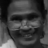

(48, 48)
Happy
[[ 80  39  11 ... 109 111 134]
 [ 79  35  10 ... 125 124 115]
 [ 68  25  11 ... 136 121  99]
 ...
 [ 46  47  38 ...  15  14  12]
 [ 43  45  40 ...  19  15  11]
 [ 40  43  41 ...  22  16  11]]
/n/n/n/n/n/n/n


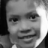

(48, 48)
Happy
[[155  11  81  81]
 [280 130  82  82]]
[[ 11  11  11 ...  77  71  65]
 [ 12  11  11 ...  78  71  66]
 [ 12  11  10 ...  78  73  70]
 ...
 [122 153 198 ...  47  49  42]
 [159 177 202 ...  56  61  47]
 [203 205 207 ...  57  72  60]]
/n/n/n/n/n/n/n


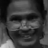

(48, 48)
Happy
[[104 102  84 ...  88 104 124]
 [102  94  71 ... 101 118 125]
 [101  94  67 ... 123 122 121]
 ...
 [ 57  58  38 ...  19  15  11]
 [ 45  51  43 ...  22  16  11]
 [ 36  49  46 ...  23  19  15]]
/n/n/n/n/n/n/n


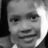

(48, 48)
Happy
[[154  12  80  80]
 [280 130  82  82]]
[[ 12  11  11 ...  79  80  74]
 [ 12  12  11 ...  79  80  75]
 [ 14  11  11 ...  78  79  77]
 ...
 [116 129 173 ...  45  44  46]
 [145 156 187 ...  49  52  59]
 [193 196 202 ...  49  53  67]]
/n/n/n/n/n/n/n


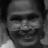

(48, 48)
Happy
[[107 101  57 ... 101 131 138]
 [100  82  42 ...  97 110 134]
 [ 96  78  37 ... 120 122 133]
 ...
 [127 129 115 ...  18  14  11]
 [ 71  89 112 ...  19  14  10]
 [ 36  36  76 ...  21  16  12]]
/n/n/n/n/n/n/n


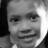

(48, 48)
Happy
[[155  12  79  79]
 [282 131  80  80]]
[[ 11  11  10 ...  80  78  71]
 [ 11  10   9 ...  81  78  72]
 [ 11  10   9 ...  79  78  73]
 ...
 [132 171 193 ...  37  42  51]
 [141 187 206 ...  40  39  43]
 [157 200 214 ...  43  51  56]]
/n/n/n/n/n/n/n


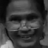

(48, 48)
Happy
[[ 13  13  16 ...  95 126 143]
 [ 12  12  12 ... 117 123 135]
 [ 12  13  11 ... 127 122 124]
 ...
 [109 108 107 ...  12  12  11]
 [108 107 104 ...  16  14  11]
 [107 104 102 ...  18  12  10]]
/n/n/n/n/n/n/n


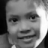

(48, 48)
Happy
[[153  12  80  80]
 [281 131  81  81]]
[[ 13  11  11 ...  81  81  74]
 [ 13  12  11 ...  80  80  75]
 [ 15  12  11 ...  80  81  77]
 ...
 [115 129 170 ...  42  38  39]
 [115 136 184 ...  46  44  51]
 [146 163 195 ...  49  45  61]]
/n/n/n/n/n/n/n


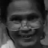

(48, 48)
Happy
[[ 12  10  11 ... 102 116 150]
 [ 10  10  10 ... 118 125 147]
 [ 11   9  10 ... 127 119 145]
 ...
 [107 104 102 ...  15  13  11]
 [101  99  97 ...  14  10  10]
 [ 97  96  94 ...  16  11  10]]
/n/n/n/n/n/n/n


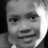

(48, 48)
Happy
[[154  13  79  79]
 [282 130  84  84]]
[[ 11  11  11 ...  81  81  74]
 [ 12  11   9 ...  80  80  75]
 [ 11  11  10 ...  80  82  78]
 ...
 [128 165 194 ...  40  38  43]
 [134 181 207 ...  43  42  44]
 [155 193 214 ...  46  49  59]]
/n/n/n/n/n/n/n


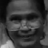

(48, 48)
Happy
[[ 11  12  11 ... 159 196 195]
 [ 10  11  11 ... 181 201 187]
 [ 10  11  11 ... 158 211 220]
 ...
 [ 87  85  85 ...   9  10  10]
 [ 78  81  81 ...   9   9   9]
 [ 74  85  80 ...   9  11  11]]
/n/n/n/n/n/n/n


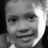

(48, 48)
Happy
[[153  13  80  80]
 [282 132  82  82]]
[[ 13  11  11 ...  81  81  72]
 [ 15  12  11 ...  81  80  73]
 [ 15  11  11 ...  80  81  74]
 ...
 [116 144 187 ...  40  40  43]
 [130 157 198 ...  45  51  56]
 [173 184 203 ...  45  54  68]]
/n/n/n/n/n/n/n


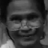

(48, 48)
Happy
[[ 10  11  11 ... 151 157 194]
 [ 10  11  11 ... 159 139 175]
 [  9  11  11 ... 172 158 167]
 ...
 [ 87  80  80 ...  10   9  10]
 [ 87  77  77 ...   9   9   9]
 [ 89  75  73 ...  10   9   9]]
/n/n/n/n/n/n/n


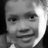

(48, 48)
Happy
[[153  12  80  80]
 [281 131  83  83]]
[[ 13  11  11 ...  81  80  71]
 [ 13  11  11 ...  81  81  72]
 [ 15  12  11 ...  81  80  73]
 ...
 [120 135 169 ...  40  42  50]
 [116 144 187 ...  40  40  43]
 [130 157 198 ...  45  51  56]]
/n/n/n/n/n/n/n


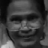

(48, 48)
Happy
[[ 20  11  12 ... 116 153 188]
 [ 12  10  11 ... 151 157 194]
 [ 10  10  11 ... 159 139 175]
 ...
 [ 89  87  80 ...  10   9  10]
 [ 86  87  77 ...   9   9   9]
 [ 80  89  75 ...  10   9   9]]
/n/n/n/n/n/n/n


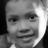

(48, 48)
Happy
[[154  15  80  80]
 [281 132  82  82]]
[[ 12  11   9 ...  81  73  71]
 [ 11  11  11 ...  79  76  71]
 [ 12  11  11 ...  78  76  71]
 ...
 [182 212 213 ...  61  60  42]
 [198 210 215 ...  65  73  52]
 [210 209 211 ...  66  82  65]]
/n/n/n/n/n/n/n


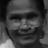

(48, 48)
Happy
[[ 38  15  16 ... 135 139 171]
 [ 35  15  15 ... 155 153 153]
 [ 24  11  12 ... 150 160 145]
 ...
 [ 89  88  82 ...  10  10  10]
 [ 85  88  80 ...  10  10   9]
 [ 77  88  80 ...  11   9   9]]
/n/n/n/n/n/n/n


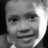

(48, 48)
Happy
[[275  98 214 214]]
[[148 139 134 ...  63  75 109]
 [153 149 145 ...  60  72 108]
 [158 163 162 ...  58  67 106]
 ...
 [150 148 145 ... 167 167 166]
 [163 151 145 ... 167 167 166]
 [174 163 151 ... 167 167 167]]
/n/n/n/n/n/n/n


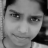

(48, 48)
Neutral
[[276  97 212 212]]
[[144 137 131 ...  27  53  66]
 [142 135 129 ...  27  52  63]
 [150 146 142 ...  27  50  61]
 ...
 [145 145 145 ... 164 162 160]
 [146 146 145 ... 167 166 165]
 [143 146 144 ... 167 167 167]]
/n/n/n/n/n/n/n


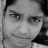

(48, 48)
Neutral
[[276  97 216 216]]
[[144 137 131 ... 115 126 136]
 [142 135 129 ... 111 122 132]
 [150 146 142 ... 108 121 131]
 ...
 [164 152 146 ... 166 167 166]
 [176 163 152 ... 167 167 167]
 [189 177 163 ... 167 167 167]]
/n/n/n/n/n/n/n


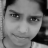

(48, 48)
Neutral
[[278 100 211 211]]
[[158 156 157 ...  29  47  77]
 [165 165 162 ...  29  47  75]
 [167 170 166 ...  29  47  75]
 ...
 [147 145 145 ... 167 167 167]
 [147 147 145 ... 167 167 167]
 [148 145 145 ... 167 167 167]]
/n/n/n/n/n/n/n


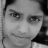

(48, 48)
Neutral
[[279  99 209 209]]
[[129 134 137 ...  15  25  43]
 [157 157 152 ...  15  25  43]
 [165 163 155 ...  15  25  43]
 ...
 [145 147 147 ... 162 159 157]
 [146 146 146 ... 165 163 160]
 [146 145 146 ... 167 167 165]]
/n/n/n/n/n/n/n


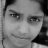

(48, 48)
Neutral
[[282 102 202 202]]
[[142 115 100 ...   6   6   9]
 [148 121 106 ...   6   6   9]
 [149 124 111 ...   6   6   9]
 ...
 [149 149 149 ... 153 144 136]
 [150 150 149 ... 156 156 153]
 [149 149 149 ... 162 159 158]]
/n/n/n/n/n/n/n


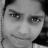

(48, 48)
Neutral


KeyboardInterrupt: ignored

In [95]:
videoToMoodDetection('/content/video.mp4')

**pixel to image**

(48, 48, 1)
(48, 48)


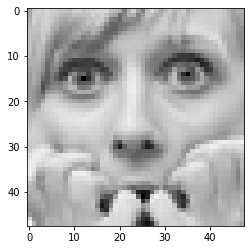

In [ ]:
import matplotlib.pyplot as plt

single_image = np.array(x_test_data[13]*255)
print(single_image.shape)
single_image = np.reshape(single_image,(48,48),order = 'C')
print(single_image.shape)
plt.imshow(single_image, cmap='gray', vmin=0, vmax=255)
# s_img = np.array(single_image, shape=(48,48))